In [1]:
from pathlib import Path
import pandas as pd
import json
import os
import numpy as np
import itertools
import torch
import torch.utils.data as data_utils
from tqdm import tqdm

from tableshift import get_dataset

import seaborn as sns
from paretoset import paretoset
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.ticker import FormatStrFormatter
import matplotlib.markers as mmark

from experiments_causal.plot_config_colors import *
from experiments_causal.plot_experiment import get_results

from statsmodels.stats.proportion import proportion_confint
from experiments_causal.plot_config_colors import *
from experiments_causal.plot_config_tasks import dic_title

# Set plot configurations
sns.set_context("paper")
sns.set_style("white")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 1200
list_mak = [
    mmark.MarkerStyle("s"),
    mmark.MarkerStyle("D"),
    mmark.MarkerStyle("o"),
    mmark.MarkerStyle("X"),
    mmark.MarkerStyle("*"),
]
list_lab = ["All", "Arguably causal", "Causal", "Constant","Random"]
list_color = [color_all, color_arguablycausal, color_causal, color_constant, plt.cm.Paired(1)]

list_mak_results = list_mak.copy()
list_mak_results.append("_")
list_lab_results = list_lab.copy()
list_lab_results.append("Diagonal")
list_color_results = list_color.copy()
list_color_results.append("black")

class MarkerHandler(HandlerBase):
    def create_artists(
        self, legend, tup, xdescent, ydescent, width, height, fontsize, trans
    ):
        return [
            plt.Line2D(
                [width / 2],
                [height / 2.0],
                ls="",
                marker=tup[1],
                markersize=markersize,
                color=tup[0],
                transform=trans,
            )
        ]
    
def get_dic_experiments_value(name: str) -> list:
    """Return list of experiment names for a task.

    Parameters
    ----------
    name : str
        The name of the task.

    Returns
    -------
    list
        List of experiment names (all features, causal features, arguably causal features).

    """
    return [f"{name}_random_test_{index}" for index in range(500)]


dic_experiments = {
    "acsemployment": get_dic_experiments_value("acsemployment"),
    "acsfoodstamps": get_dic_experiments_value("acsfoodstamps"),
    "acsincome": get_dic_experiments_value("acsincome"),
    "acspubcov": get_dic_experiments_value("acspubcov"),
    "acsunemployment": get_dic_experiments_value("acsunemployment"),
    "anes": get_dic_experiments_value("anes"),
    "assistments": get_dic_experiments_value("assistments"),
    "brfss_blood_pressure": get_dic_experiments_value("brfss_blood_pressure"),
    "brfss_diabetes": get_dic_experiments_value("brfss_diabetes"),
    "college_scorecard": get_dic_experiments_value("college_scorecard"),
    "diabetes_readmission": get_dic_experiments_value("diabetes_readmission"),
    "meps": get_dic_experiments_value("meps"),
    "mimic_extract_los_3": get_dic_experiments_value("mimic_extract_los_3"),
    "mimic_extract_mort_hosp": get_dic_experiments_value("mimic_extract_mort_hosp"),
    "nhanes_lead": get_dic_experiments_value("nhanes_lead"),
    "physionet": get_dic_experiments_value("physionet"),
    "sipp": get_dic_experiments_value("sipp"),
}

def get_results_random_subsets(experiment_name: str) -> pd.DataFrame:

    """Load json files of experiments from results folder, concat them into a dataframe and save it.

    Parameters
    ----------
    experiment_name : str
        The name of the task.

    Returns
    -------
    pd.DataFrame
        Dataframe containing the results of the experiment.

    """
    experiments = dic_experiments[experiment_name]

    # Load all json files of experiments
    eval_all = pd.DataFrame()
    feature_selection = []
    for experiment in experiments:
        file_info = []
        try:
            RESULTS_DIR = Path(__file__).parents[0] / "add_on_results" / "random_subset" / experiment
            for filename in os.listdir(RESULTS_DIR):
                if filename == ".DS_Store":
                    pass
                else:
                    file_info.append(filename)

            for run in file_info:
                with open(str(RESULTS_DIR / run), "rb") as file:
                    # print(str(RESULTS_DIR / run))
                    try:
                        eval_json = json.load(file)
                        eval_pd = pd.DataFrame(
                            [
                                {
                                    "id_test": eval_json["id_test"],
                                    "id_test_lb": eval_json["id_test" + "_conf"][0],
                                    "id_test_ub": eval_json["id_test" + "_conf"][1],
                                    "ood_test": eval_json["ood_test"],
                                    "ood_test_lb": eval_json["ood_test" + "_conf"][0],
                                    "ood_test_ub": eval_json["ood_test" + "_conf"][1],
                                    "validation": eval_json["validation"],
                                    "features": f"random_{experiment.split('_')[-1]}",
                                    "model": run.split("_", 2)[0] + "_" + run.split("_", 2)[1] if run.split("_")[0] in ["ib", "and", "causirl"] else run.split("_")[0],
                                    "number": len(eval_json["features"]),
                                }
                            ]
                        )
                        eval_all = pd.concat([eval_all, eval_pd], ignore_index=True)
                    except:
                        print(str(RESULTS_DIR / run))
        except:
            print(experiment)

    # Select model with highest in-domain validation accuracy
    list_model_data = []
    for set in eval_all["features"].unique():
        eval_feature = eval_all[eval_all["features"] == set]
        for model in eval_feature["model"].unique():
            model_data = eval_feature[eval_feature["model"] == model]
            model_data = model_data[
                model_data["validation"] == model_data["validation"].max()
            ]
            model_data.drop_duplicates(inplace=True)
            list_model_data.append(model_data)
    eval_all = pd.concat(list_model_data)
    return eval_all

# def plot_results(experiment_name: str):
    
experiments = [
    "acsfoodstamps",
    "acsincome",
    "acspubcov",
    "acsunemployment",
    "anes",
    "assistments",
    "brfss_blood_pressure",
    "brfss_diabetes",
    "college_scorecard",
    "diabetes_readmission",
    # "mimic_extract_mort_hosp",
    # "mimic_extract_los_3",
    "nhanes_lead",
    "physionet",
    "meps",
    "sipp",
]

/opt/anaconda3/envs/causaldiscovery/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

acsincome_random_test_202
acsincome_random_test_319
acsincome_random_test_366


<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

acspubcov_random_test_0
acspubcov_random_test_3
acspubcov_random_test_20
acspubcov_random_test_41
acspubcov_random_test_64
acspubcov_random_test_77
acspubcov_random_test_82
acspubcov_random_test_83
acspubcov_random_test_84
acspubcov_random_test_86
acspubcov_random_test_87
acspubcov_random_test_88
acspubcov_random_test_92
acspubcov_random_test_98
acspubcov_random_test_100
acspubcov_random_test_106
acspubcov_random_test_111
acspubcov_random_test_117
acspubcov_random_test_125
acspubcov_random_test_140
acspubcov_random_test_143
acspubcov_random_test_144
acspubcov_random_test_145
acspubcov_random_test_147
acspubcov_random_test_155
acspubcov_random_test_168
acspubcov_random_test_170
acspubcov_random_test_172
acspubcov_random_test_178
acspubcov_random_test_180
acspubcov_random_test_183
acspubcov_random_test_186
acspubcov_random_test_193
acspubcov_random_test_195
acspubcov_random_test_201
acspubcov_random_test_216
acspubcov_random_test_223
acspubcov_random_test_241
acspubcov_random_test_248
ac

<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

acspubcov Adv. Label DRO
acspubcov CORAL
acspubcov DANN
acspubcov Group DRO
acspubcov IRM
acspubcov MMD
acspubcov MixUp
acspubcov VREX


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

acsunemployment_random_test_110


<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

assistments_random_test_463
assistments_random_test_464
assistments_random_test_465
assistments_random_test_466
assistments_random_test_467
assistments_random_test_468
assistments_random_test_469
assistments_random_test_470
assistments_random_test_471
assistments_random_test_472
assistments_random_test_473
assistments_random_test_474
assistments_random_test_475
assistments_random_test_476
assistments_random_test_477
assistments_random_test_478
assistments_random_test_479
assistments_random_test_480
assistments_random_test_481
assistments_random_test_482
assistments_random_test_483
assistments_random_test_484
assistments_random_test_485
assistments_random_test_486
assistments_random_test_487
assistments_random_test_488
assistments_random_test_489
assistments_random_test_490
assistments_random_test_491
assistments_random_test_492
assistments_random_test_493
assistments_random_test_494
assistments_random_test_495
assistments_random_test_496
assistments_random_test_497
assistments_random_t

<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments/xgb_eval_33.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments/xgb_eval_11.json


100%|██████████| 649/649 [00:00<00:00, 3244461.62it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments_causal/histgbm_eval_42.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments_causal/xgb_eval_1.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments_causal/xgb_eval_45.json


100%|██████████| 645/645 [00:00<00:00, 3160427.66it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/assistments_arguablycausal/xgb_eval_35.json
assistments Adv. Label DRO
assistments CORAL
assistments DANN
assistments Group DRO
assistments IRM
assistments MMD
assistments MixUp
assistments VREX


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

brfss_blood_pressure CORAL
brfss_blood_pressure DANN
brfss_blood_pressure Group DRO
brfss_blood_pressure IRM
brfss_blood_pressure MMD
brfss_blood_pressure MixUp
brfss_blood_pressure VREX


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/brfss_diabetes_arguablycausal/xgb_eval_36.json


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

college_scorecard_random_test_1
college_scorecard_random_test_3
college_scorecard_random_test_4
college_scorecard_random_test_5
college_scorecard_random_test_6
college_scorecard_random_test_7
college_scorecard_random_test_8
college_scorecard_random_test_9
college_scorecard_random_test_10
college_scorecard_random_test_11
college_scorecard_random_test_13
college_scorecard_random_test_14
college_scorecard_random_test_15
college_scorecard_random_test_18
college_scorecard_random_test_19
college_scorecard_random_test_28
college_scorecard_random_test_29
college_scorecard_random_test_30
college_scorecard_random_test_31
college_scorecard_random_test_32
college_scorecard_random_test_33
college_scorecard_random_test_34
college_scorecard_random_test_35
college_scorecard_random_test_36
college_scorecard_random_test_37
college_scorecard_random_test_40
college_scorecard_random_test_45
college_scorecard_random_test_46
college_scorecard_random_test_47
college_scorecard_random_test_48
college_scorecard_

<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

diabetes_readmission_random_test_2
diabetes_readmission_random_test_8
diabetes_readmission_random_test_10
diabetes_readmission_random_test_12
diabetes_readmission_random_test_18
diabetes_readmission_random_test_21
diabetes_readmission_random_test_23
diabetes_readmission_random_test_25
diabetes_readmission_random_test_26
diabetes_readmission_random_test_34
diabetes_readmission_random_test_35
diabetes_readmission_random_test_36
diabetes_readmission_random_test_37
diabetes_readmission_random_test_40
diabetes_readmission_random_test_42
diabetes_readmission_random_test_48
diabetes_readmission_random_test_50
diabetes_readmission_random_test_53
diabetes_readmission_random_test_61
diabetes_readmission_random_test_65
diabetes_readmission_random_test_66
diabetes_readmission_random_test_67
diabetes_readmission_random_test_76
diabetes_readmission_random_test_77
diabetes_readmission_random_test_101
diabetes_readmission_random_test_106
diabetes_readmission_random_test_117
diabetes_readmission_random

<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/diabetes_readmission/histgbm_eval_38.json


100%|██████████| 1191/1191 [00:00<00:00, 1877975.96it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/diabetes_readmission_causal/histgbm_eval_11.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/diabetes_readmission_causal/xgb_eval_17.json


100%|██████████| 1195/1195 [00:00<00:00, 2825362.62it/s]
<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/nhanes_lead/histgbm_eval_30.json


100%|██████████| 642/642 [00:00<00:00, 3488009.28it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/nhanes_lead_causal/histgbm_eval_10.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/nhanes_lead_causal/xgb_eval_36.json


100%|██████████| 646/646 [00:00<00:00, 1362252.58it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/nhanes_lead_arguablycausal/xgb_eval_7.json
nhanes_lead CORAL
nhanes_lead DANN
nhanes_lead Group DRO
nhanes_lead IRM
nhanes_lead MMD
nhanes_lead MixUp
nhanes_lead VREX


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/physionet/histgbm_eval_23.json


100%|██████████| 649/649 [00:00<00:00, 3562962.43it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/physionet_causal/xgb_eval_17.json


100%|██████████| 649/649 [00:00<00:00, 2213092.11it/s]


physionet CORAL
physionet DANN
physionet Group DRO
physionet IRM
physionet MMD
physionet MixUp
physionet VREX


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

meps_random_test_127
meps_random_test_203
meps_random_test_209
meps_random_test_243
meps_random_test_254
meps_random_test_260
meps_random_test_261
meps_random_test_263
meps_random_test_274
meps_random_test_297
meps_random_test_299
meps_random_test_311
meps_random_test_329
meps_random_test_336
meps_random_test_338
meps_random_test_341
meps_random_test_345
meps_random_test_351
meps_random_test_353
meps_random_test_358
meps_random_test_363
meps_random_test_368
meps_random_test_369
meps_random_test_370
meps_random_test_371
meps_random_test_374
meps_random_test_377
meps_random_test_381
meps_random_test_382
meps_random_test_383
meps_random_test_386
meps_random_test_387
meps_random_test_392
meps_random_test_393
meps_random_test_396
meps_random_test_411
meps_random_test_412
meps_random_test_413
meps_random_test_443
meps_random_test_444
meps_random_test_449
meps_random_test_463
meps_random_test_466
meps_random_test_467
meps_random_test_468
meps_random_test_469
meps_random_test_470
meps_random_t

<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_plot.sort_values("id_test", inplace=True)
<ipython-input-2-d487aec405bd>:51: SettingWithCopyWarni

/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/sipp/xgb_eval_4.json


100%|██████████| 646/646 [00:00<00:00, 3244934.59it/s]


/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/sipp_arguablycausal/histgbm_eval_24.json
/Users/vnastl/Seafile/My Library/mpi project causal vs noncausal/causal-features/experiments_causal/results/sipp_arguablycausal/xgb_eval_31.json


<ipython-input-2-d487aec405bd>:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["type"] = "constant"
<ipython-input-2-d487aec405bd>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
<ipython-input-2-d487aec405bd>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

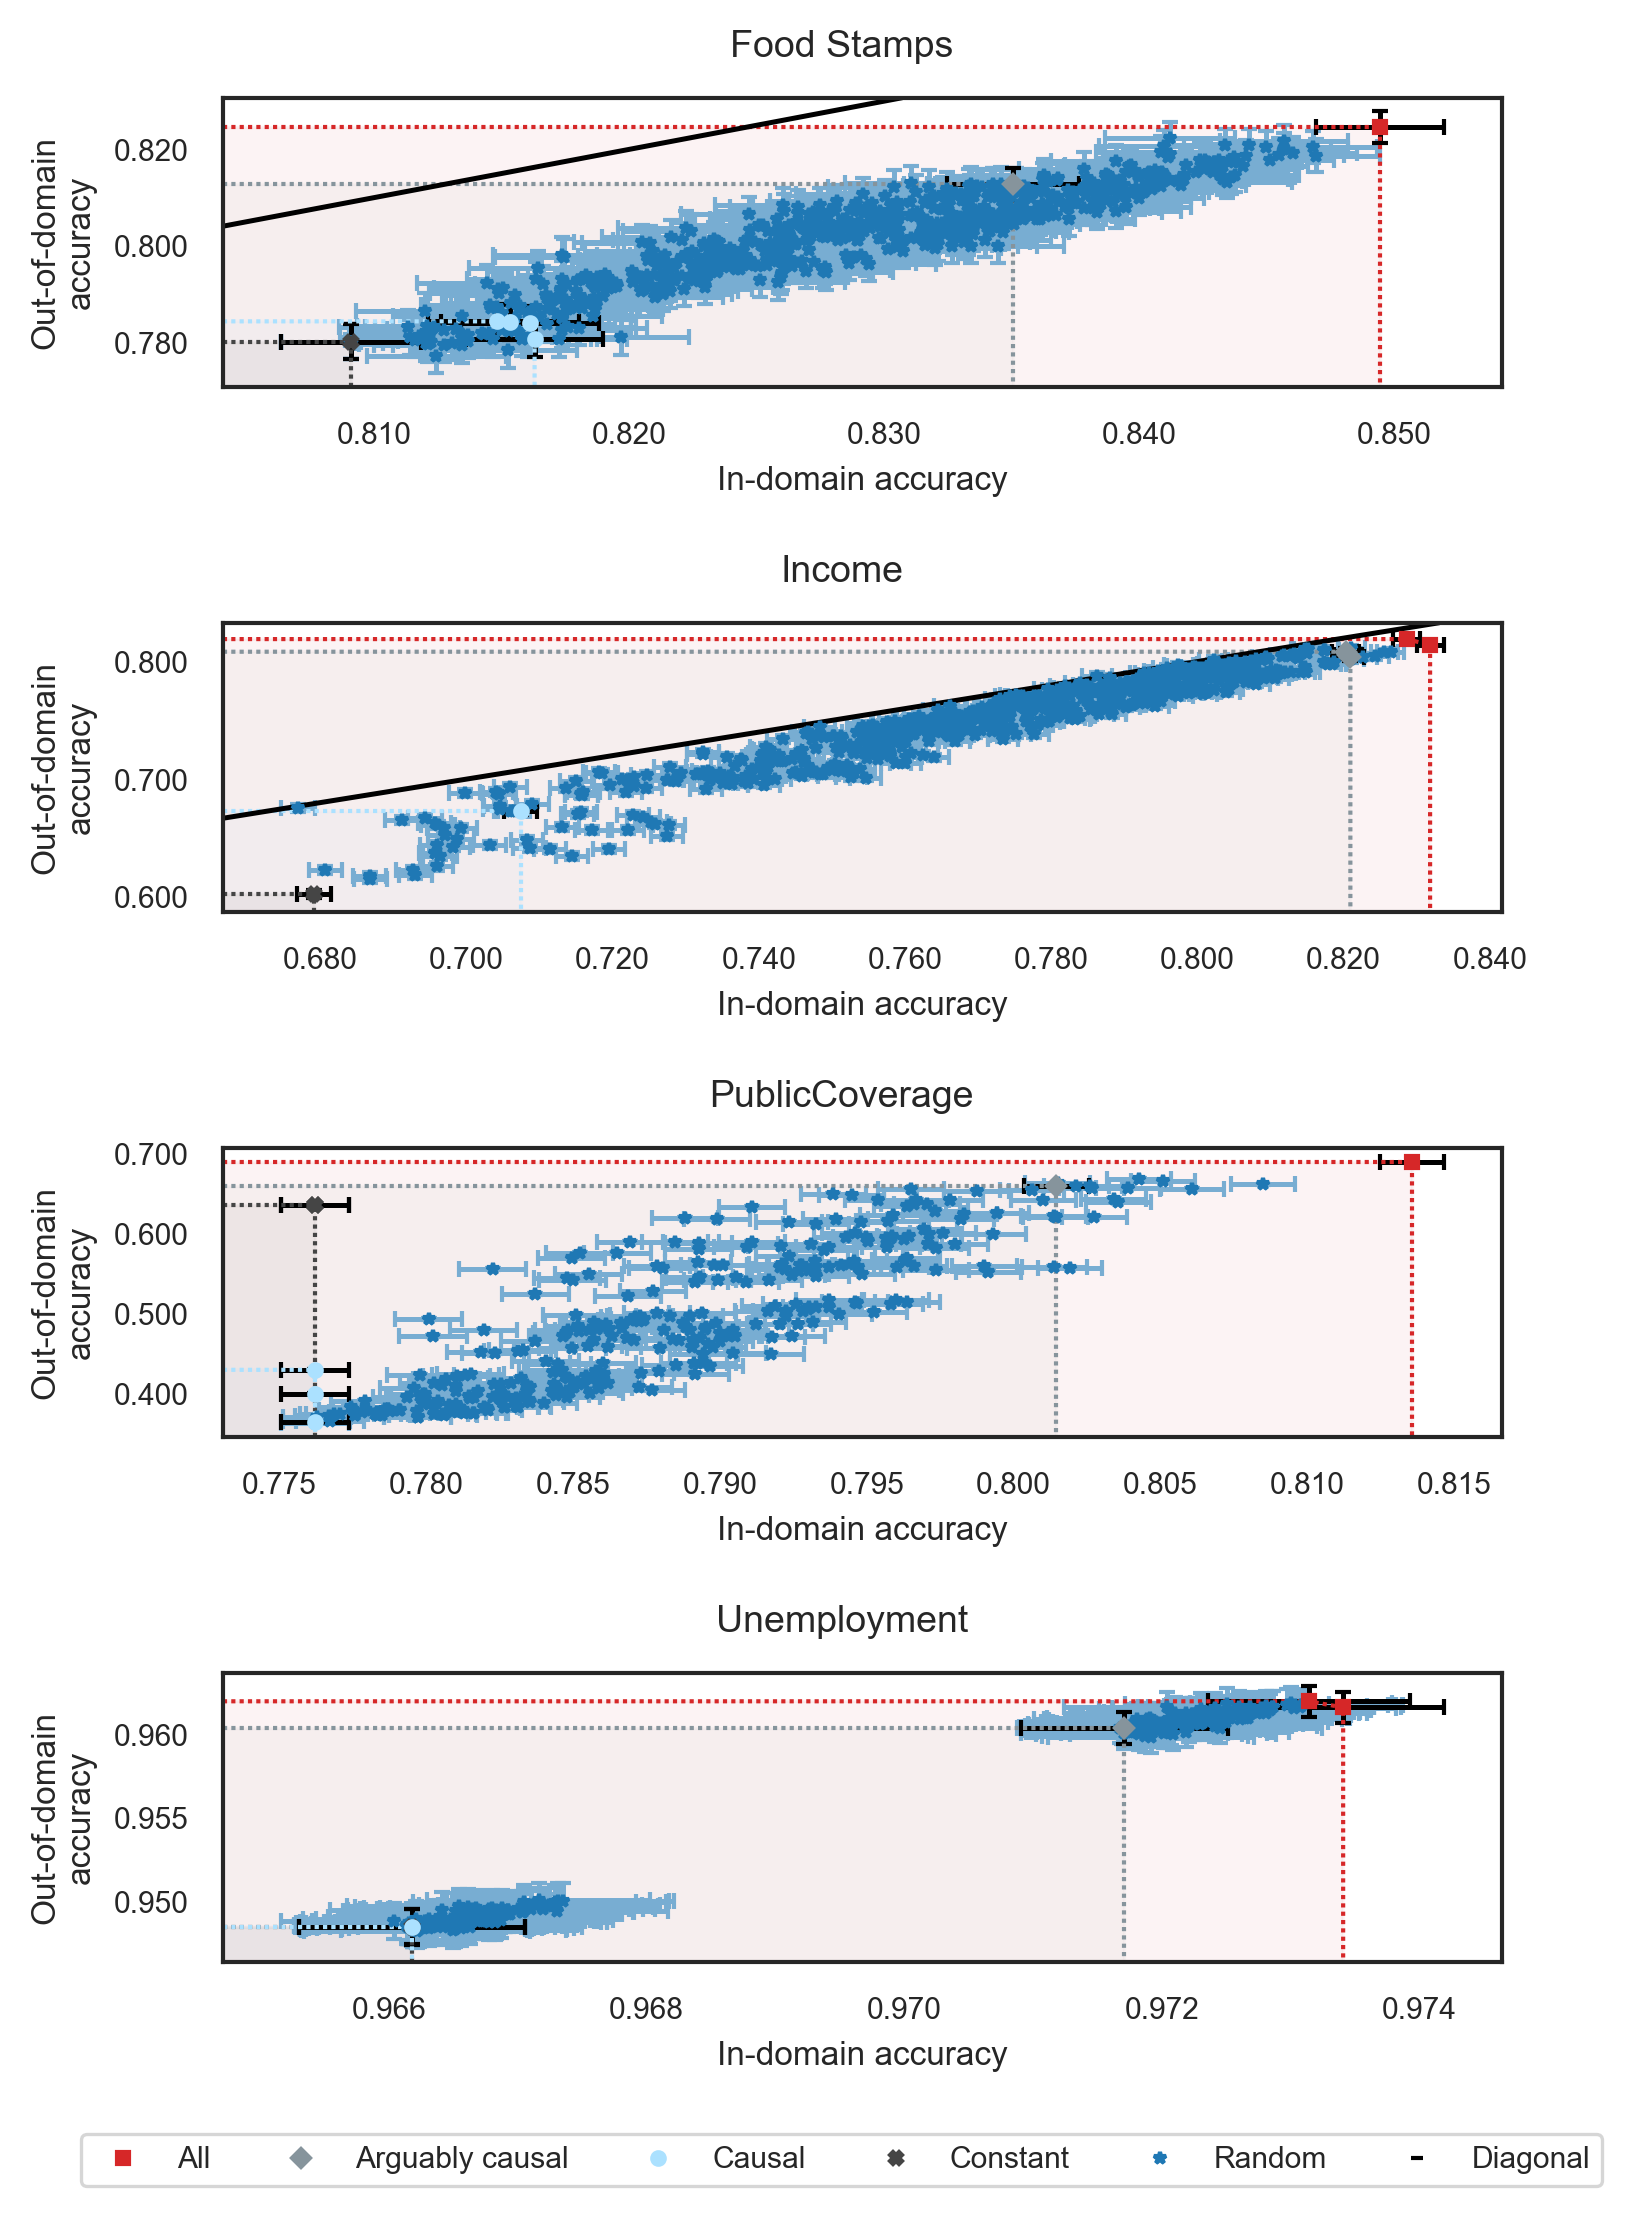

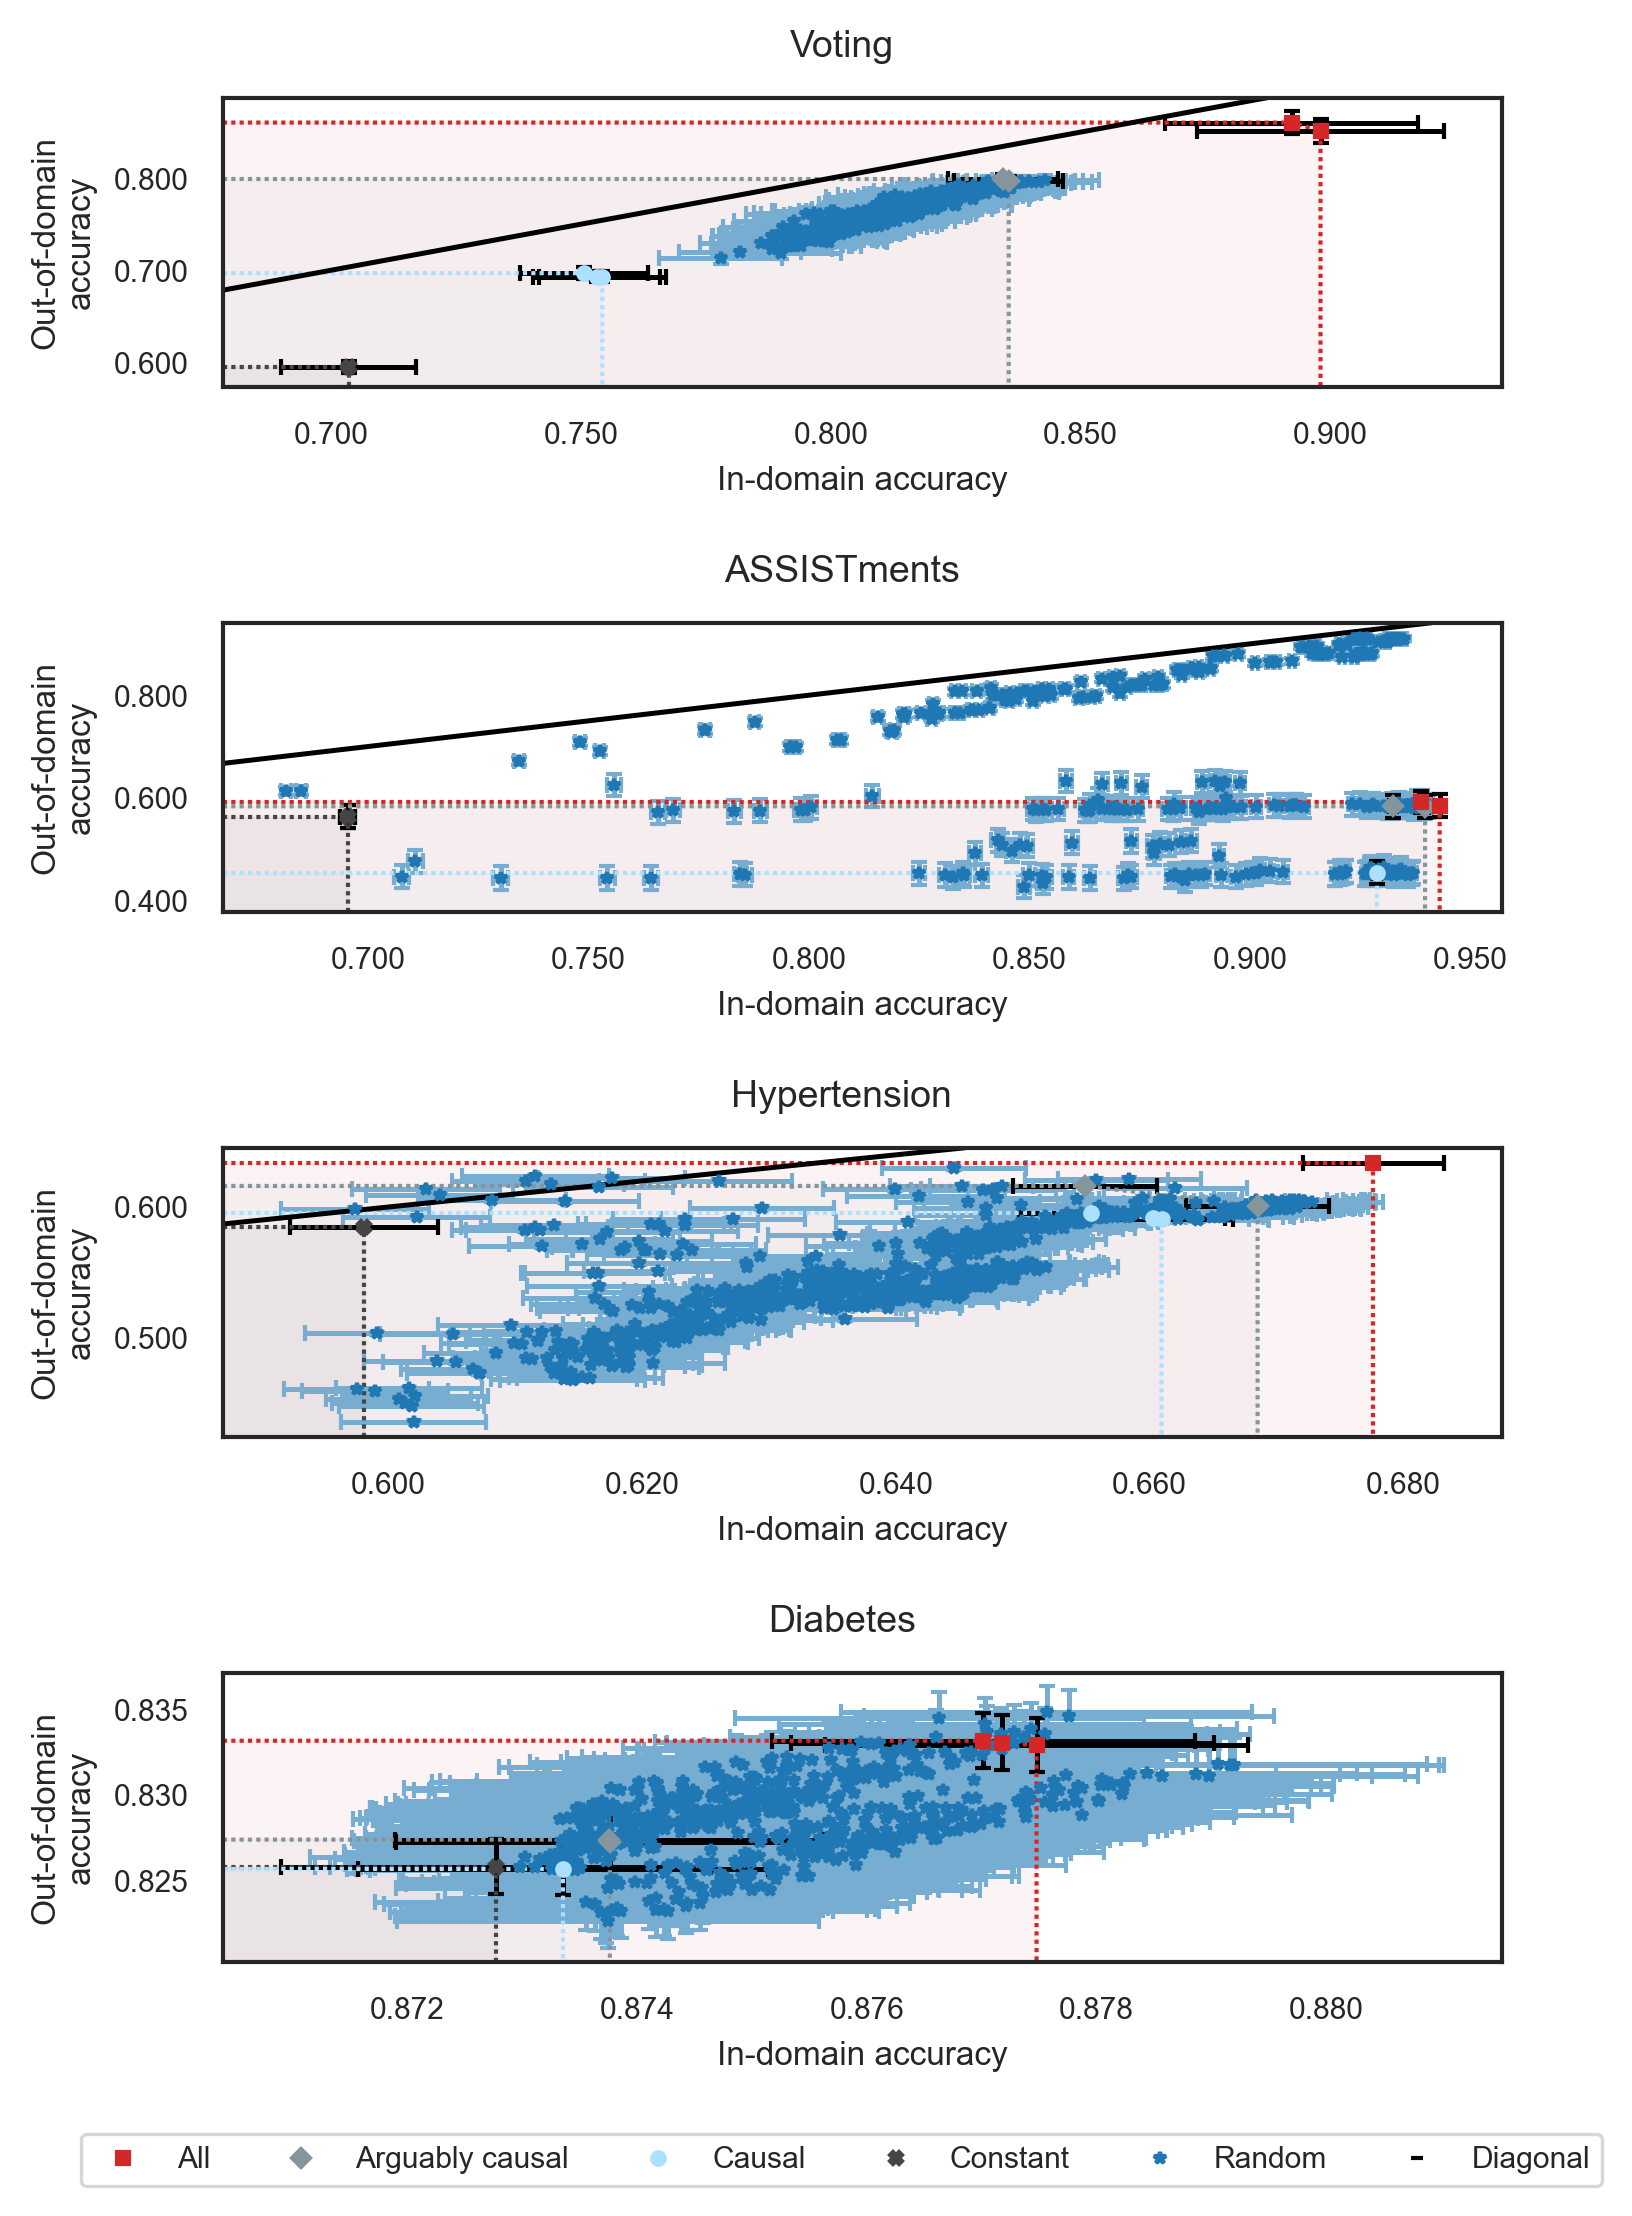

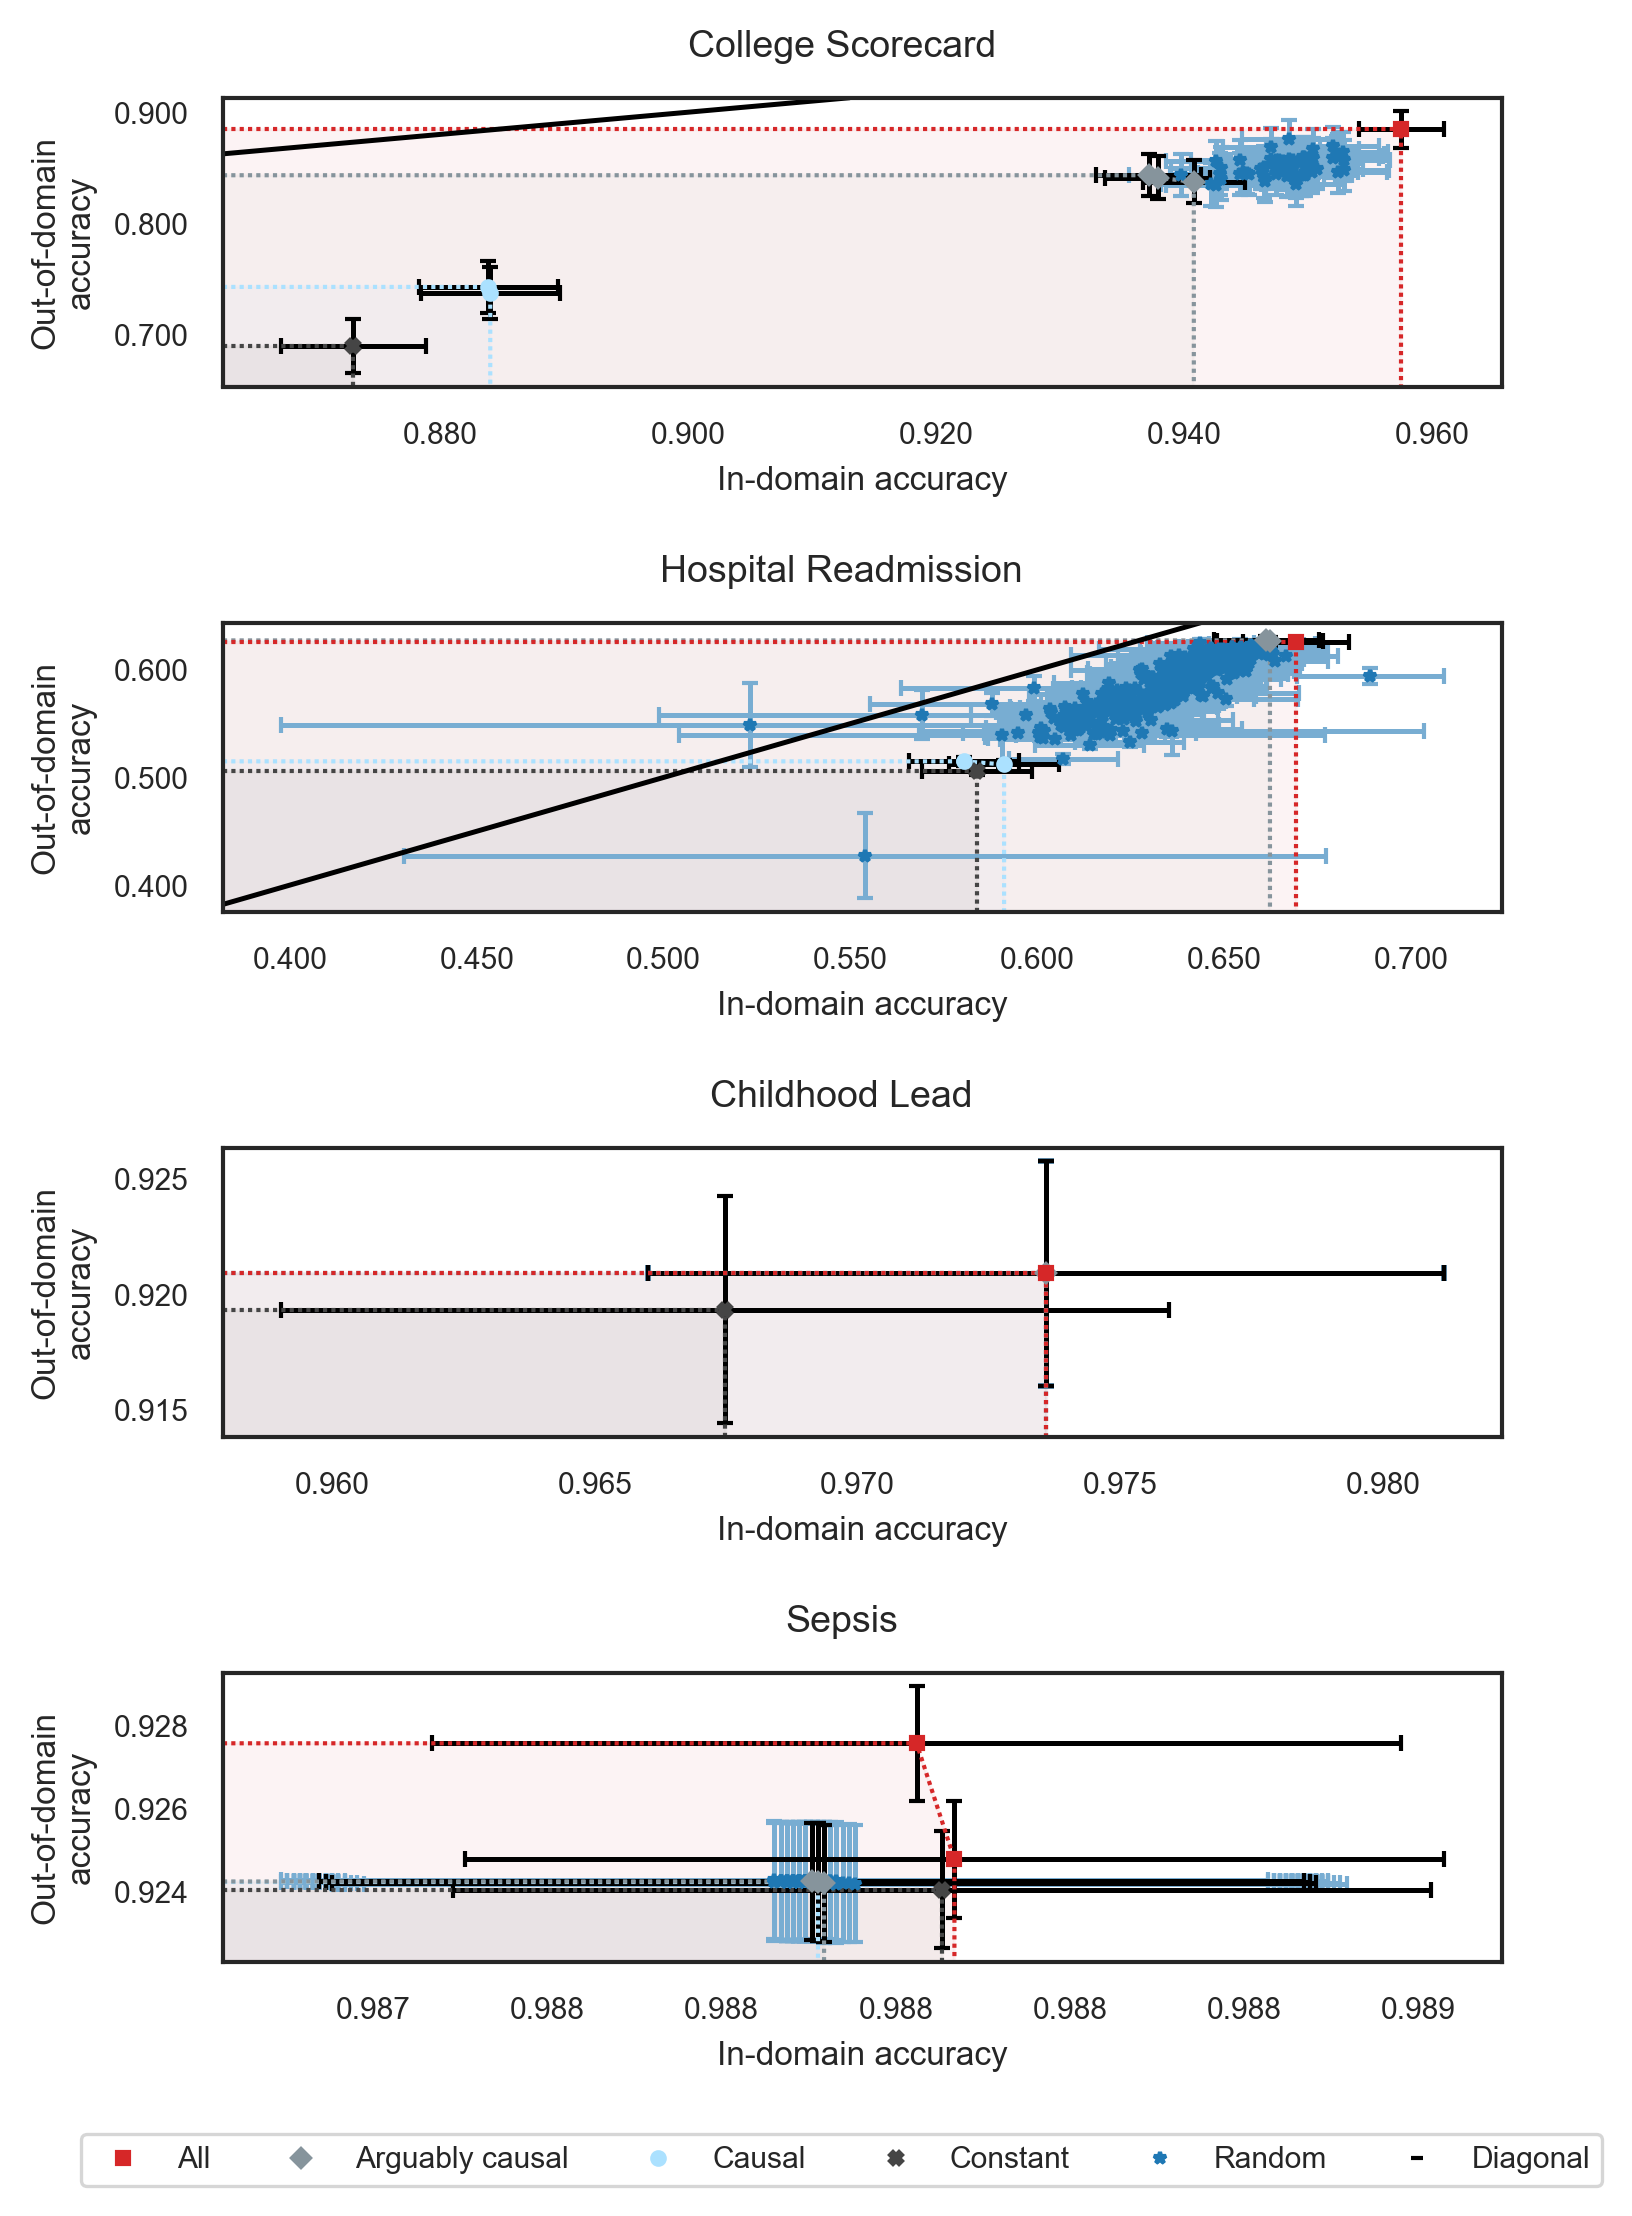

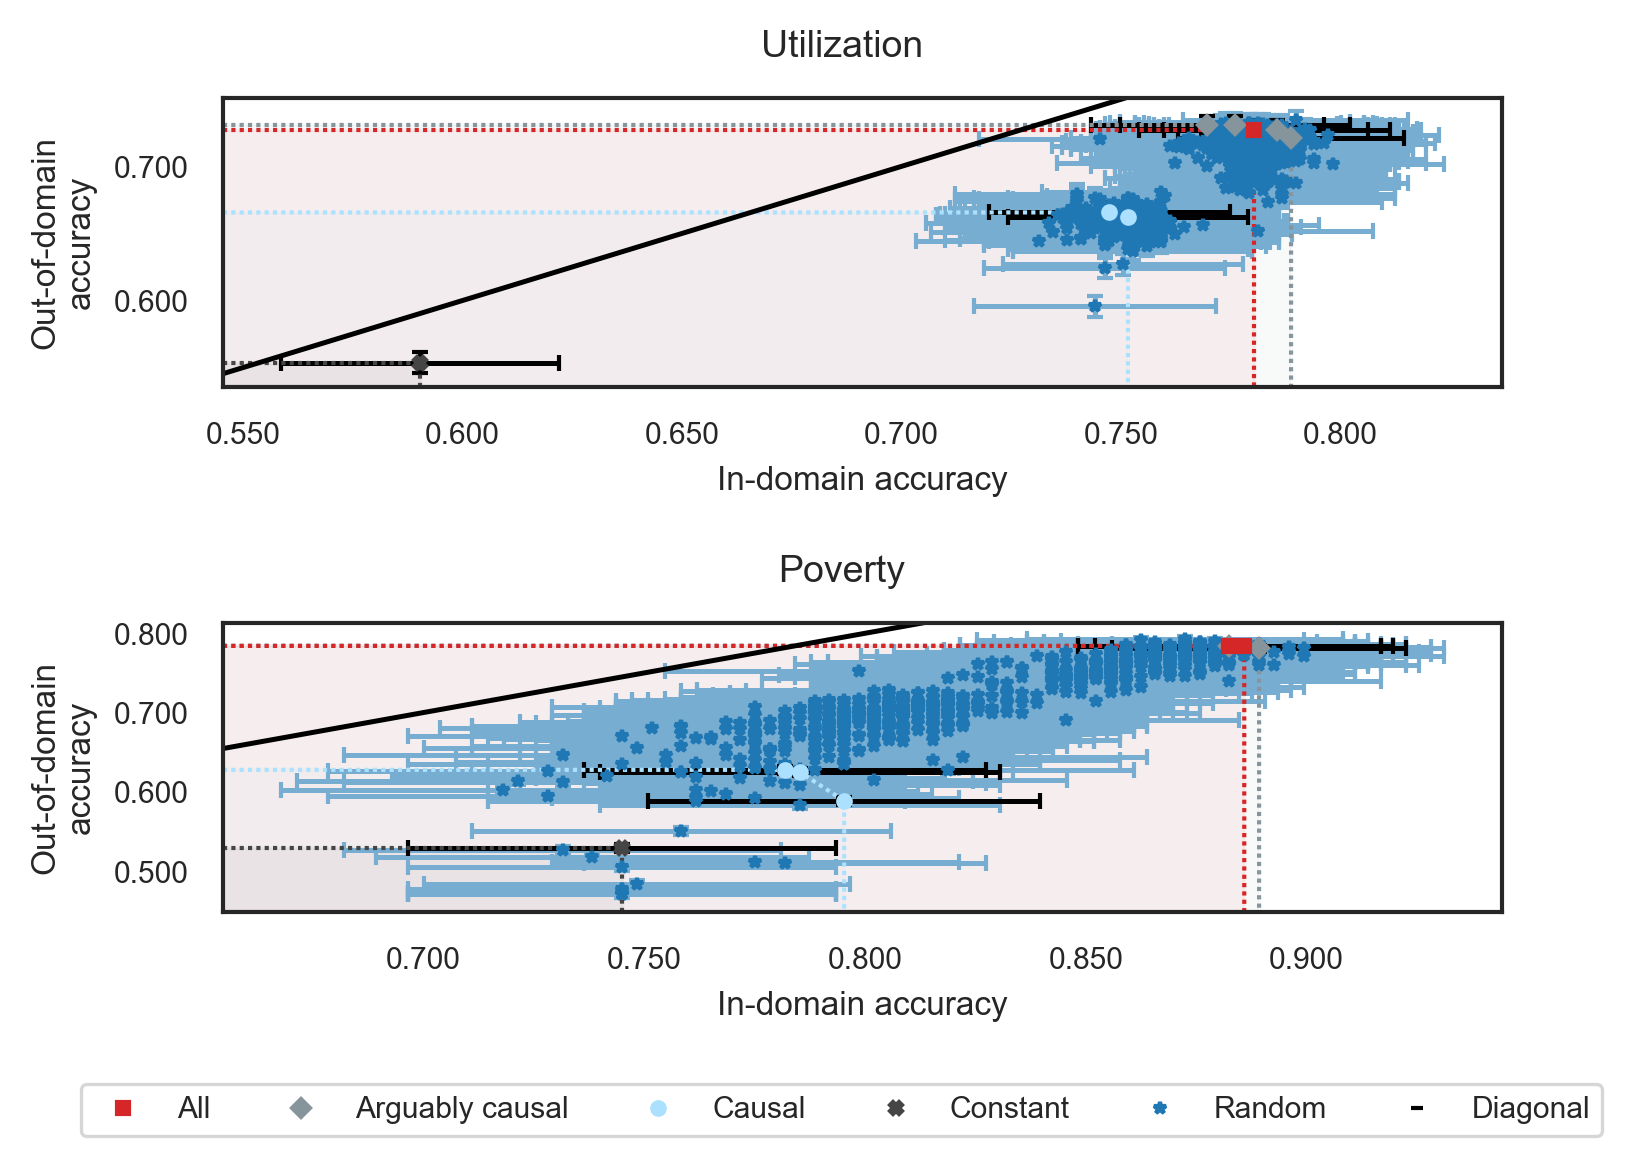

In [2]:
for index, experiment_name in enumerate(experiments):
    sns.set_style("white")
    if index % 4 == 0:
        if index == 12:
            fig = plt.figure(figsize=[5.5, 3.5])
            (subfig1, subfig2) = fig.subfigures(2, 1, hspace=0.5)  # create 2x1 subfigures

            subfigs = (subfig1, subfig2)

            ax1 = subfig1.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig1
            ax2 = subfig2.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig2
            axes = (ax1, ax2)
        else:
            fig = plt.figure(figsize=[5.5, 7])
            (subfig1, subfig2, subfig3, subfig4) = fig.subfigures(4, 1, hspace=0.5)  # create 4x1 subfigures

            subfigs = (subfig1, subfig2, subfig3, subfig4)

            ax1 = subfig1.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig1
            ax2 = subfig2.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig2
            ax3 = subfig3.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig2
            ax4 = subfig4.subplots(
                1, 1, gridspec_kw={"top": 0.85}
            )  # create 1x4 subplots on subfig2
            axes = (ax1, ax2, ax3, ax4)

    subfig = subfigs[index % 4]
    subfig.subplots_adjust(wspace=0.4, bottom=0.3)
    ax = axes[index % 4]
    subfig.suptitle(dic_title[experiment_name], fontsize=9)  # set suptitle for subfig1
    # ax.set_title(dic_title[experiment_name], fontsize=9)  # set suptitle for subfig1
    #############################################################################
    # plot errorbars for random features
    #############################################################################
    eval_all_random = get_results_random_subsets(experiment_name)

    for set in eval_all_random["features"].unique():
        eval_plot = eval_all_random[eval_all_random["features"] == set]
        eval_plot.sort_values("id_test", inplace=True)
        # Calculate the pareto set
        points = eval_plot[["id_test", "ood_test"]]
        mask = paretoset(points, sense=["max", "max"])
        markers = eval_plot[mask]
        errors = ax.errorbar(
            x=markers["id_test"],
            y=markers["ood_test"],
            xerr=markers["id_test_ub"] - markers["id_test"],
            yerr=markers["ood_test_ub"] - markers["ood_test"],
            fmt="*",
            color=plt.cm.Paired(1),
            ecolor="#78add2",
            markersize=markersize,
            capsize=capsize,
        )

    eval_all = get_results(experiment_name)

    eval_constant = eval_all[eval_all["features"] == "constant"]
    dic_shift_acc = {}

    ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))

    ax.set_xlabel(f"In-domain accuracy")
    ax.set_ylabel(f"Out-of-domain\naccuracy")

    #############################################################################
    # plot errorbars for constant
    #############################################################################
    errors = ax.errorbar(
        x=eval_constant["id_test"],
        y=eval_constant["ood_test"],
        xerr=eval_constant["id_test_ub"] - eval_constant["id_test"],
        yerr=eval_constant["ood_test_ub"] - eval_constant["ood_test"],
        fmt="X",
        color=color_constant,
        ecolor=color_error,
        markersize=markersize,
        capsize=capsize,
        label="constant",
    )
    # get pareto set for shift vs accuracy
    shift_acc = eval_constant
    shift_acc["type"] = "constant"
    shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
    dic_shift_acc["constant"] = shift_acc

    #############################################################################
    # plot errorbars for causal features
    #############################################################################
    eval_plot = eval_all[eval_all["features"] == "causal"]
    eval_plot.sort_values("id_test", inplace=True)
    # Calculate the pareto set
    points = eval_plot[["id_test", "ood_test"]]
    mask = paretoset(points, sense=["max", "max"])
    markers = eval_plot[mask]
    markers = markers[markers["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
    errors = ax.errorbar(
        x=markers["id_test"],
        y=markers["ood_test"],
        xerr=markers["id_test_ub"] - markers["id_test"],
        yerr=markers["ood_test_ub"] - markers["ood_test"],
        fmt="o",
        color=color_causal,
        ecolor=color_error,
        markersize=markersize,
        capsize=capsize,
        label="causal",
    )
    # get pareto set for shift vs accuracy
    shift_acc = eval_plot[
        eval_plot["ood_test"] == eval_plot["ood_test"].max()
    ].drop_duplicates()
    shift_acc["type"] = "causal"
    shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
    dic_shift_acc["causal"] = shift_acc
    #############################################################################
    # plot errorbars for arguablycausal features
    #############################################################################
    if (eval_all["features"] == "arguablycausal").any():
        eval_plot = eval_all[eval_all["features"] == "arguablycausal"]
        eval_plot.sort_values("id_test", inplace=True)
        # Calculate the pareto set
        points = eval_plot[["id_test", "ood_test"]]
        mask = paretoset(points, sense=["max", "max"])
        markers = eval_plot[mask]
        markers = markers[
            markers["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)
        ]
        errors = ax.errorbar(
            x=markers["id_test"],
            y=markers["ood_test"],
            xerr=markers["id_test_ub"] - markers["id_test"],
            yerr=markers["ood_test_ub"] - markers["ood_test"],
            fmt="D",
            color=color_arguablycausal,
            ecolor=color_error,
            markersize=markersize,
            capsize=capsize,
            label="arguably\ncausal",
        )
        # get pareto set for shift vs accuracy
        shift_acc = eval_plot[
            eval_plot["ood_test"] == eval_plot["ood_test"].max()
        ].drop_duplicates()
        shift_acc["type"] = "arguablycausal"
        shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
        dic_shift_acc["arguablycausal"] = shift_acc

    #############################################################################
    # plot errorbars for all features
    #############################################################################
    eval_plot = eval_all[eval_all["features"] == "all"]
    eval_plot.sort_values("id_test", inplace=True)
    # Calculate the pareto set
    points = eval_plot[["id_test", "ood_test"]]
    mask = paretoset(points, sense=["max", "max"])
    markers = eval_plot[mask]
    markers = markers[markers["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
    errors = ax.errorbar(
        x=markers["id_test"],
        y=markers["ood_test"],
        xerr=markers["id_test_ub"] - markers["id_test"],
        yerr=markers["ood_test_ub"] - markers["ood_test"],
        fmt="s",
        color=color_all,
        ecolor=color_error,
        markersize=markersize,
        capsize=capsize,
        label="all",
    )
    # get pareto set for shift vs accuracy
    shift_acc = eval_plot[
        eval_plot["ood_test"] == eval_plot["ood_test"].max()
    ].drop_duplicates()
    shift_acc["type"] = "all"
    shift_acc["gap"] = shift_acc["id_test"] - shift_acc["ood_test"]
    dic_shift_acc["all"] = shift_acc

    #############################################################################
    # plot pareto dominated area for constant
    #############################################################################
    xmin, xmax = ax.set_xlim()
    ymin, ymax = ax.set_ylim()
    ax.plot(
        [xmin, eval_constant["id_test"].values[0]],
        [eval_constant["ood_test"].values[0], eval_constant["ood_test"].values[0]],
        color=color_constant,
        linestyle=(0, (1, 1)),
        linewidth=linewidth_bound,
    )
    ax.plot(
        [eval_constant["id_test"].values[0], eval_constant["id_test"].values[0]],
        [ymin, eval_constant["ood_test"].values[0]],
        color=color_constant,
        linestyle=(0, (1, 1)),
        linewidth=linewidth_bound,
    )
    ax.fill_between(
        [xmin, eval_constant["id_test"].values[0]],
        [ymin, ymin],
        [eval_constant["ood_test"].values[0], eval_constant["ood_test"].values[0]],
        color=color_constant,
        alpha=0.05,
    )

    #############################################################################
    # plot pareto dominated area for causal features
    #############################################################################
    eval_plot = eval_all[eval_all["features"] == "causal"]
    eval_plot.sort_values("id_test", inplace=True)
    # Calculate the pareto set
    points = eval_plot[["id_test", "ood_test"]]
    mask = paretoset(points, sense=["max", "max"])
    points = points[mask]
    points = points[points["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
    markers = eval_plot[mask]
    markers = markers[markers["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
    # get extra points for the plot
    new_row = pd.DataFrame(
        {
            "id_test": [xmin, max(points["id_test"])],
            "ood_test": [max(points["ood_test"]), ymin],
        },
    )
    points = pd.concat([points, new_row], ignore_index=True)
    points.sort_values("id_test", inplace=True)
    ax.plot(
        points["id_test"],
        points["ood_test"],
        color=color_causal,
        linestyle=(0, (1, 1)),
        linewidth=linewidth_bound,
    )
    new_row = pd.DataFrame(
        {"id_test": [xmin], "ood_test": [ymin]},
    )
    points = pd.concat([points, new_row], ignore_index=True)
    points = points.to_numpy()
    hull = ConvexHull(points)
    ax.fill(
        points[hull.vertices, 0], points[hull.vertices, 1], color=color_causal, alpha=0.05
    )

    #############################################################################
    # plot pareto dominated area for arguablycausal features
    #############################################################################
    if (eval_all["features"] == "arguablycausal").any():
        eval_plot = eval_all[eval_all["features"] == "arguablycausal"]
        eval_plot.sort_values("id_test", inplace=True)
        # Calculate the pareto set
        points = eval_plot[["id_test", "ood_test"]]
        mask = paretoset(points, sense=["max", "max"])
        points = points[mask]
        points = points[points["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
        # get extra points for the plot
        new_row = pd.DataFrame(
            {
                "id_test": [xmin, max(points["id_test"])],
                "ood_test": [max(points["ood_test"]), ymin],
            },
        )
        points = pd.concat([points, new_row], ignore_index=True)
        points.sort_values("id_test", inplace=True)
        ax.plot(
            points["id_test"],
            points["ood_test"],
            color=color_arguablycausal,
            linestyle=(0, (1, 1)),
            linewidth=linewidth_bound,
        )
        new_row = pd.DataFrame(
            {"id_test": [xmin], "ood_test": [ymin]},
        )
        points = pd.concat([points, new_row], ignore_index=True)
        points = points.to_numpy()
        hull = ConvexHull(points)
        ax.fill(
            points[hull.vertices, 0],
            points[hull.vertices, 1],
            color=color_arguablycausal,
            alpha=0.05,
        )

    #############################################################################
    # plot pareto dominated area for all features
    #############################################################################
    eval_plot = eval_all[eval_all["features"] == "all"]
    eval_plot.sort_values("id_test", inplace=True)
    # Calculate the pareto set
    points = eval_plot[["id_test", "ood_test"]]
    mask = paretoset(points, sense=["max", "max"])
    points = points[mask]
    points = points[points["id_test"] >= (eval_constant["id_test"].values[0] - 0.01)]
    # get extra points for the plot
    new_row = pd.DataFrame(
        {
            "id_test": [xmin, max(points["id_test"])],
            "ood_test": [max(points["ood_test"]), ymin],
        },
    )
    points = pd.concat([points, new_row], ignore_index=True)
    points.sort_values("id_test", inplace=True)
    ax.plot(
        points["id_test"],
        points["ood_test"],
        color=color_all,
        linestyle=(0, (1, 1)),
        linewidth=linewidth_bound,
    )
    new_row = pd.DataFrame(
        {"id_test": [xmin], "ood_test": [ymin]},
    )
    points = pd.concat([points, new_row], ignore_index=True)
    points = points.to_numpy()
    hull = ConvexHull(points)
    ax.fill(
        points[hull.vertices, 0], points[hull.vertices, 1], color=color_all, alpha=0.05
    )

    #############################################################################
    # Add legend & diagonal, save plot
    #############################################################################
    # Plot the diagonal line
    start_lim = max(xmin, ymin)
    end_lim = min(xmax, ymax)
    ax.plot([start_lim, end_lim], [start_lim, end_lim], color=color_error)

    if index % 4 == 3:
        fig.legend(
        list(zip(list_color_results, list_mak_results)),
        list_lab_results,
        handler_map={tuple: MarkerHandler()},
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        fancybox=True,
        ncol=6,
        )

        fig.savefig(
            str(Path(__file__).parents[0] / f"plots_add_on/plot_random_subsets_{int(index/4)}.pdf"),
            bbox_inches="tight",
        )

        fig.show()

    elif index == 13:
        fig.legend(
        list(zip(list_color_results, list_mak_results)),
        list_lab_results,
        handler_map={tuple: MarkerHandler()},
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        fancybox=True,
        ncol=6,
        )

        fig.savefig(
            str(Path(__file__).parents[0] / f"plots_add_on/plot_random_subsets_{int(5)}.pdf"),
            bbox_inches="tight",
        )
        fig.show()

In [3]:
eval_assistments = get_results_random_subsets("assistments")

assistments_random_test_463
assistments_random_test_464
assistments_random_test_465
assistments_random_test_466
assistments_random_test_467
assistments_random_test_468
assistments_random_test_469
assistments_random_test_470
assistments_random_test_471
assistments_random_test_472
assistments_random_test_473
assistments_random_test_474
assistments_random_test_475
assistments_random_test_476
assistments_random_test_477
assistments_random_test_478
assistments_random_test_479
assistments_random_test_480
assistments_random_test_481
assistments_random_test_482
assistments_random_test_483
assistments_random_test_484
assistments_random_test_485
assistments_random_test_486
assistments_random_test_487
assistments_random_test_488
assistments_random_test_489
assistments_random_test_490
assistments_random_test_491
assistments_random_test_492
assistments_random_test_493
assistments_random_test_494
assistments_random_test_495
assistments_random_test_496
assistments_random_test_497
assistments_random_t

In [4]:
eval_assistments = eval_assistments[eval_assistments["ood_test"]>0.7]

In [5]:
eval_assistments

,id_test,id_test_lb,id_test_ub,ood_test,ood_test_lb,ood_test_ub,validation,features,model,number
0,0.925510,0.924846,0.926171,0.910006,0.904858,0.914962,0.925871,random_0,xgb,9
1,0.776475,0.775428,0.777520,0.732333,0.724485,0.740072,0.775269,random_1,xgb,6
3,0.932255,0.931621,0.932884,0.909926,0.904776,0.914884,0.931876,random_3,xgb,10
4,0.819339,0.818367,0.820308,0.731215,0.723357,0.738965,0.819748,random_4,xgb,7
9,0.924350,0.923684,0.925012,0.910006,0.904858,0.914962,0.923832,random_9,xgb,6
...,...,...,...,...,...,...,...,...,...,...
453,0.866347,0.865491,0.867200,0.832149,0.825486,0.838657,0.865752,random_453,xgb,7
457,0.924392,0.923726,0.925054,0.881019,0.875220,0.886640,0.923996,random_457,xgb,6
458,0.932468,0.931835,0.933096,0.909846,0.904694,0.914806,0.931997,random_458,xgb,11
459,0.865128,0.864265,0.865989,0.799090,0.791963,0.806077,0.864985,random_459,xgb,7


In [6]:
"""
For more information on datasets and access in TableShift, see:
* https://tableshift.org/datasets.html
* https://github.com/mlfoundations/tableshift

Modified for 'Predictors from Causal Features Do Not Generalize Better to New Domains'.
"""
import numpy as np
from pandas import DataFrame

from tableshift.core.features import Feature, FeatureList, cat_dtype
from tableshift.datasets.robustness import get_causal_robust, get_arguablycausal_robust, get_random_subset


ASSISTMENTS_FEATURES = FeatureList(features=[
    Feature('Average_confidence(BORED)', float),
    Feature('Average_confidence(CONCENTRATING)', float),
    Feature('Average_confidence(CONFUSED)', float),
    Feature('Average_confidence(FRUSTRATED)', float),
    Feature('attempt_count', int),
    Feature('hint_count', int),
    Feature('school_id', float),
    Feature('skill_id', float,
            value_mapping={
                54.0: "Rounding",
                279.0: "Multiplication and Division Integers",
                79.0: "Proportion",
                86.0: "Exponents",
                311.0: "Equation Solving Two or Fewer Steps",
                11.0: "Venn Diagram",
                280.0: "Addition and Subtraction Fractions",
                338.0: "Combining Like Terms",
                81.0: "Unit Rate",
                325.0: "Write Linear Equation from Graph",
                322.0: "Write Linear Equation from Ordered Pairs",
                13.0: "Median",
                312.0: "Equation Solving More Than Two Steps",
                75.0: "Square Root",
                336.0: "Finding y-intercept from Linear Equation",
                315.0: "Parallel and Perpendicular Lines",
                340.0: "Distributive Property",
                70.0: "Percent Of",
                67.0: "Multiplication Fractions",
                277.0: "Addition and Subtraction Integers",
                24.0: "Congruence",
                363.0: "Multiplying non Monomial Polynomials",
                309.0:      "Order of Operations +,-,/,* () positive reals",
                324.0: "Recognize Linear Pattern",
                333.0: "Finding Slope From Equation",
                25.0: "Complementary and Supplementary Angles",
                378.0: "Solving Systems of Linear Equations by Graphing",
                49.0: "Ordering Positive Decimals",
                110.0: "D.4.8-understanding-concept-of-probabilities",
                42.0: "Perimeter of a Polygon",
                368.0: "Solving for a variable",
                12.0: "Mean",
                103.0: "Point Plotting",
                34.0: "Unit Conversion Within a System",
                47.0: "Conversion of Fraction Decimals Percents",
                61.0: "Division Fractions",
                296.0: "Area Rectangle",
                82.0: "Scientific Notation",
                15.0: "Range",
                51.0: "Ordering Integers",
                27.0: "Pythagorean Theorem",
                307.0: "Volume Rectangular Prism",
                65.0: "Least Common Multiple",
                323.0: "Write Linear Equation from Situation",
                326.0: "Write Linear Equation from Slope and y-intercept",
                46.0: "Calculations with Similar Figures",
                278.0: "Addition and Subtraction Positive Decimals",
                299.0: "Surface Area Cylinder",
                8.0: "Scatter Plot",
                77.0: "Finding Percents",
                163.0: "Absolute Value",
                523.0: "Picking Expressions From Choices",
                310.0: "Order of Operations All",
                80.0: "Scale Factor",
                297.0: "Area Trapezoid",
                39.0: "Area Circle",
                301.0: "Surface Area Rectangular Prism",
                302.0: "Surface Area Sphere",
                53.0: "Ordering Real Numbers",
                166.0: "Algebraic Solving",
                21.0: "Interior Angles Figures with More than 3 Sides",
                92.0: "Pattern Finding ",
                95.0: "Substitution",
                17.0: "Probability of Two Distinct Events",
                288.0: "Properties and Classification Rectangular Prisms",
                334.0: "Finding Slope from Ordered Pairs",
                282.0: "Properties and Classification Polygons with 5 or more sides",
                281.0: "Properties and Classification Triangles",
                371.0: "Simplifying Expressions positive exponents",
                84.0: "Prime Number",
                580.0: "Exponents",
                48.0: "Equivalent Fractions",
                314.0: "Angles - Obtuse, Acute, and Right",
                1.0: "Box and Whisker",
                362.0: "Parts of a Polyomial, Terms, Coefficient, Monomial, Exponent, Variable",
                350.0: "Solving Systems of Linear Equations",
                4.0: "Histogram as Table or Graph",
                306.0: "Volume Pyramid",
                298.0: "Area Triangle",
                83.0: "Divisibility Rules",
                294.0: "Area Irregular Figure",
                588.0: "Equivalent Fractions",
                577.0: "Nets of 3D Objects",
                331.0: "Finding Slope From Situation",
                569.0: "Surface Area Rectangular Prism",
                22.0: "Interior Angles Triangle",
                36.0: "Unit Conversion Standard to Metric",
                346.0: "Polynomial Factors",
                317.0: "Greatest Common Factor",
                332.0: "Finding Slope from Graph",
                90.0: "Picking Equation and Inequality from Choices",
                303.0: "Volume Cylinder",
                173.0: "Choose an Equation from Given Information",
                308.0: "Volume Sphere",
                217.0: "Rate",
                356.0: "Quadratic Formula to Solve Quadratic Equation",
                40.0: "Circumference ",
                283.0: "Properties and Classification Quadrilaterals",
                343.0: "Midpoint",
                295.0: "Area Parallelogram",
                392.0: "Surface Area of Prism",
                50.0: "Ordering Fractions",
                41.0: "Definition Pi",
                5.0: "Number Line",
                287.0: "Properties and Classification Prism",
                18.0: "Probability of a Single Event",
                276.0: "Multiplication and Division Positive Decimals",
                63.0: "Estimation",
                292.0: "Rotations",
                26.0: "Angles on Parallel Lines Cut by a Transversal",
                572.0: "Circumference",
                575.0: "Concept Volume",
                58.0: "Addition Whole Numbers",
                85.0: "Absolute Value",
                186.0: "Histogram as Table or Graph",
                358.0: "Making a Table from an Equation",
                284.0: "Properties and Classification Circle",
                584.0: "Multiplication Proper Fractions",
                574.0: "Subtraction Mixed Fractions",
                576.0: "Area Rectangle",
                366.0: "Composition of Function Adding",
                305.0: "Volume Cone",
                354.0: "Factoring Polynomials Standard",
                304.0: "Volume Prism",
                319.0: "Prime Factor",
                591.0: "Subtraction Proper Fractions",
                582.0: "Multiplication Positive Decimals",
                587.0: "Least Common Multiple",
                16.0: "Counting Methods",
                32.0: "Nets of 3D Figures",
                88.0: "Inverse Relations",
                365.0: "Interpreting Coordinate Graphs ",
                106.0: "Graph Shape",
                33.0: "English and Metric Terminology",
                375.0: "Solving Inequalities",
                1641.0: "Finding Ratios",
                62.0: "Division Whole Numbers",
                7.0: "Sampling Techniques",
                290.0: "Reflection",
                203.0: "Percent Discount",
                339.0: "Bar Graph",
                240.0: "X-Y Graph Reading",
                69.0: "Multiplication Whole Numbers",
                222.0: "Solving Inequalities",
                316.0: "Expanded, Standard and Word Notation",
                74.0: "Subtraction Whole Numbers",
                321.0: "Computation with Real Numbers",
                78.0: "Percent Increase or Decrease",
                391.0: "Graphing Linear Equations",
                230.0: "Surface Area of 3D Objects",
                327.0: "Comparing and Identifying Slope/Rate of Change",
                293.0: "Translations",
                10.0: "Table",
                300.0: "Surface Area Pyramid",
                9.0: "Stem and Leaf Plot",
                613.0: "Addition Mixed Fractions",
                360.0: "Writine Expression from Diagrams",
                387.0: "Perimeter of an Irregular Figure",
                14.0: "Mode",
                64.0: "Fraction Of",
                202.0: "Pattern Finding",
                318.0: "Multiplication Division by Powers of 10",
                344.0: "Distance Formula",
                231.0: "Symbolization",
                223.0: "Solving System of Equation",
                226.0: "Substitution",
                204.0: "Percents",
                6.0: "Line Plot",
                214.0: "Quadratic Equation Solving",
                585.0: "Division Proper Fractions",
                578.0: "Area Parallelogram",
                181.0: "Exponents",
                581.0: "Circle Concept",
                570.0: "Area Trapezoid",
                233.0: "Transformation",
                571.0: "Area Circle",
                583.0: "Multiplication Mixed Fractions",
                579.0: "Area Triangle",
                589.0: "Addition Proper Fractions",
                393.0: "Associative Property",
                198.0: "Median",
                370.0: "Recognizing Equivalent Expressions",
                376.0: "Graphing Inequalities on a number line",
                388.0: "Common Multiple",
                595.0: "Area Circle",
                599.0: "Concept Volume",
                52.0: "Ordering Whole Numbers",
                601.0: "Area Parallelogram",
                596.0: "Circumference",
                359.0: "Commutative Property",
                172.0: "Calculation with + - * /",
                2.0: "Circle Graph",
                224.0: "Square Roots",
                586.0: "Greatest Common Factor",
                35.0: "Effect of Changing Dimensions of a Shape Prportionally",
                568.0: "Volume Rectangular Prism",
                573.0: "Division Mixed Fractions",
                192.0: "Line of Best-Fit",
                238.0: "Volume of 3D Objects",
                345.0: "Properties and Clasification of Pyramid",
                605.0: "Multiplication Positive Decimals",
                313.0: "Tree Diagrams, Lists for Counting",
                597.0: "Division Mixed Fractions",
                216.0: "Range",
                386.0: "Odd and Even Number",
                213.0: "Pythagorean Theorem",
                206.0: "Factoring Trinomials",
                289.0: "Line Symmetry",
                165.0: "Algebraic Simplification",
                610.0: "Least Common Multiple",
                390.0: "Graph Shape",
                389.0: "Common Factor",
                212.0: "Proportion",
                593.0: "Surface Area Rectangular Prism",
                609.0: "Greatest Common Factor",
                606.0: "Multiplication Mixed Fractions",
                598.0: "Subtraction Mixed Fractions",
                385.0: "Elapsed Time",
                590.0: "Addition Mixed Fractions",
                594.0: "Area Trapezoid",
                184.0: "Geometric Definitions",
                218.0: "Finding Ratios",
                197.0: "Mean-Median-Mode-Range Differentiation",
                600.0: "Area Rectangle",
                196.0: "Mean",
                361.0: "Recognizing Expressions or Equations from Diagrams",
                603.0: "Exponents",
                614.0: "Subtraction Proper Fractions",
                608.0: "Division Proper Fractions",
                602.0: "Area Triangle",
                220.0: "Similar Figures",
                355.0: "Solve Quadratic Equations Using Factoring",
                592.0: "Volume Rectangular Prism",
                43.0: "Reading a Ruler or Scale",
                320.0: "Equal As Balance Concept",
                209.0: "Properties of Numbers",
                607.0: "Multiplication Proper Fractions",
                174.0: "Circle Graph",
                604.0: "Circle Concept",
                348.0: "Recognize Quadratic Pattern",
                612.0: "Addition Proper Fractions",
                178.0: "Combinatorics",
                611.0: "Equivalent Fractions",
                291.0: "Rotational Symmetry",
                177.0: "Co-ordinate Points",
            }),
    Feature('problem_type', cat_dtype),
    Feature('bottom_hint', float,
            value_mapping={0.: 'False', 1: 'True'}),
    Feature('ms_first_response', int),
    Feature('tutor_mode', cat_dtype),
    Feature('position', int),
    Feature('type', cat_dtype),
    Feature('overlap_time', int),
    Feature('first_action', int,
            value_mapping={
                0: 'Answer',
                1: 'Hint',
                2: 'Scaffold'
            }),
    # There are other text features in this dataset that would be useful for
    # text-only models; i.e. answer_text
    Feature('correct', int, is_target=True)
],
    documentation="https://www.kaggle.com/datasets/nicolaswattiez/skillbuilder-data-2009-2010 ,"
                  "https://sites.google.com/site/assistmentsdata/datasets/2012-13-school-data-with-affect")


def preprocess_assistments(df: DataFrame) -> DataFrame:
    # keep only binary correct/incorrect
    df = df[np.isin(df.correct.values, (0, 1))]
    return df


SCHOOL_IDS = [1.0, 73.0, 76.0, 139.0, 397.0, 1357.0, 1404.0, 1411.0, 1645.0,
              1689.0, 1862.0, 1998.0, 2268.0, 2770.0, 4720.0, 4724.0, 5006.0,
              5018.0, 5040.0, 5092.0, 5126.0, 5159.0, 5459.0, 5479.0, 5555.0,
              5843.0, 5872.0, 5887.0, 5897.0, 5922.0, 6090.0, 6144.0, 6257.0,
              6987.0, 7288.0, 7301.0, 7335.0, 7495.0, 7572.0, 7591.0, 7603.0,
              7703.0, 7740.0, 7760.0, 7796.0, 7804.0, 7806.0, 7836.0, 7839.0,
              7884.0, 7905.0, 8483.0, 8653.0, 8784.0, 8889.0, 8905.0, 8936.0,
              9180.0, 9208.0, 9214.0, 9270.0, 9362.0, 9409.0, 9481.0, 9495.0,
              9537.0, 9587.0, 9627.0, 9713.0, 9793.0, 9941.0, 9948.0, 10134.0,
              10152.0, 10725.0, 11154.0, 11195.0, 11230.0, 11234.0, 11247.0,
              11249.0, 11252.0, 11274.0, 11281.0, 11296.0, 11313.0, 11334.0,
              11338.0, 11357.0, 11378.0, 11390.0, 11404.0, 11446.0, 11475.0,
              11482.0, 11484.0, 11513.0, 11539.0, 11553.0, 11562.0, 11576.0,
              11594.0, 11720.0, 11772.0, 11791.0, 11823.0, 11857.0, 11876.0,
              11889.0, 11894.0, 11904.0, 11906.0, 11915.0, 11918.0, 11924.0,
              11930.0, 11931.0, 11943.0, 11944.0, 11950.0, 11954.0, 11955.0,
              11967.0, 11975.0, 11976.0, 11977.0, 11986.0, 11987.0, 11989.0,
              11996.0, 12011.0, 12012.0, 12021.0, 12026.0, 12038.0, 12056.0,
              12068.0, 12069.0, 12076.0, 12084.0, 12085.0, 12089.0, 12091.0,
              12097.0, 12116.0, 12138.0, 12141.0, 12148.0, 12154.0, 12164.0,
              12175.0, 12197.0, 12200.0, 12205.0, 12208.0, 12215.0, 12217.0,
              12221.0, 12223.0, 12225.0, 12238.0, 12240.0, 12246.0, 12248.0,
              12252.0, 12256.0, 12268.0, 12272.0, 12273.0, 12279.0, 12334.0,
              12364.0, 12367.0, 12388.0, 12406.0, 12408.0, 12412.0, 12419.0,
              np.nan, 4732.0, 4780.0, 4812.0, 4829.0, 4838.0, 4986.0, 5046.0,
              5048.0, 5049.0, 5056.0, 5062.0, 5068.0, 5098.0, 5104.0, 5106.0,
              5109.0, 5116.0, 5117.0, 5125.0, 5177.0, 5197.0, 5255.0, 5260.0,
              5307.0, 5308.0, 5309.0, 5366.0, 5399.0, 5405.0, 5406.0, 5441.0,
              5444.0, 5445.0, 5446.0, 5449.0, 5450.0, 5451.0, 5497.0, 5536.0,
              5545.0, 5550.0, 5558.0, 5559.0, 5561.0, 5689.0, 5692.0, 5721.0,
              5750.0, 5751.0, 5754.0, 5757.0, 5758.0, 5759.0, 5775.0, 5790.0,
              5797.0, 5809.0, 5874.0, 5905.0, 5906.0, 5909.0, 5910.0, 5913.0,
              5917.0, 5978.0, 5994.0, 6004.0, 6012.0, 6023.0, 6042.0, 6063.0,
              6089.0, 6123.0, 6168.0, 6177.0, 6197.0, 6205.0, 6232.0, 6246.0,
              6260.0, 6351.0, 6380.0, 6390.0, 6443.0, 6504.0, 6546.0, 6550.0,
              6553.0, 6842.0, 6905.0, 6963.0, 6977.0, 6979.0, 6992.0, 6995.0,
              7007.0, 7148.0, 7184.0, 7200.0, 7206.0, 7212.0, 7213.0, 7227.0,
              7265.0, 7304.0, 7313.0, 7340.0, 7349.0, 7359.0, 7367.0, 7389.0,
              7445.0, 7450.0, 7466.0, 7526.0, 7561.0, 7594.0, 7596.0, 7604.0,
              7630.0, 7654.0, 7674.0, 7777.0, 7778.0, 7782.0, 7787.0, 7801.0,
              7840.0, 7856.0, 7857.0, 7900.0, 7929.0, 7930.0, 7992.0, 8003.0,
              8040.0, 8041.0, 8051.0, 8086.0, 8096.0, 8207.0, 8253.0, 8264.0,
              8265.0, 8272.0, 8332.0, 8359.0, 8411.0, 8423.0, 8430.0, 8471.0,
              8478.0, 8534.0, 8554.0, 8574.0, 8646.0, 8687.0, 8744.0, 8747.0,
              8771.0, 8772.0, 8781.0, 8806.0, 8828.0, 8900.0, 9100.0, 9112.0,
              9155.0, 9161.0, 9178.0, 9186.0, 9193.0, 9203.0, 9221.0, 9241.0,
              9252.0, 9253.0, 9313.0, 9314.0, 9343.0, 9354.0, 9376.0, 9377.0,
              9394.0, 9446.0, 9450.0, 9456.0, 9486.0, 9518.0, 9532.0, 9534.0,
              9548.0, 9596.0, 9603.0, 9605.0, 9609.0, 9620.0, 9625.0, 9638.0,
              9660.0, 9667.0, 9668.0, 9684.0, 9703.0, 9727.0, 9735.0, 9775.0,
              9840.0, 9880.0, 9884.0, 9903.0, 10120.0, 10180.0, 10241.0,
              10284.0, 10323.0, 10399.0, 10410.0, 10499.0, 10735.0, 10736.0,
              10766.0, 11073.0, 11079.0, 11142.0, 11169.0, 11171.0, 11178.0,
              11180.0, 11220.0, 11228.0, 11229.0, 11231.0, 11233.0, 11236.0,
              11248.0, 11254.0, 11255.0, 11261.0, 11262.0, 11263.0, 11264.0,
              11266.0, 11267.0, 11277.0, 11280.0, 11283.0, 11294.0, 11297.0,
              11302.0, 11312.0, 11315.0, 11317.0, 11318.0, 11320.0, 11321.0,
              11322.0, 11330.0, 11335.0, 11350.0, 11362.0, 11364.0, 11368.0,
              11371.0, 11372.0, 11384.0, 11385.0, 11393.0, 11394.0, 11397.0,
              11398.0, 11403.0, 11409.0, 11416.0, 11418.0, 11420.0, 11422.0,
              11443.0, 11449.0, 11451.0, 11456.0, 11463.0, 11469.0, 11479.0,
              11481.0, 11486.0, 11502.0, 11505.0, 11509.0, 11514.0, 11518.0,
              11519.0, 11529.0, 11531.0, 11540.0, 11542.0, 11546.0, 11555.0,
              11564.0, 11572.0, 11575.0, 11580.0, 11589.0, 11590.0, 11600.0,
              11604.0, 11609.0, 11633.0, 11679.0, 11696.0, 11742.0, 11746.0,
              11749.0, 11757.0, 11765.0, 11770.0, 11773.0, 11779.0, 11782.0,
              11788.0, 11803.0, 11808.0, 11811.0, 11813.0, 11864.0, 11868.0,
              11875.0, 11878.0, 11883.0, 11884.0, 11885.0, 11887.0, 11888.0,
              11890.0, 11891.0, 11895.0, 11896.0, 11901.0, 11903.0, 11905.0,
              11909.0, 11910.0, 11912.0, 11913.0, 11916.0, 11917.0, 11920.0,
              11925.0, 11929.0, 11933.0, 11935.0, 11936.0, 11938.0, 11939.0,
              11941.0, 11942.0, 11945.0, 11946.0, 11947.0, 11948.0, 11949.0,
              11951.0, 11956.0, 11959.0, 11960.0, 11961.0, 11962.0, 11963.0,
              11964.0, 11966.0, 11971.0, 11973.0, 11983.0, 11991.0, 11992.0,
              11993.0, 11995.0, 11998.0, 12003.0, 12005.0, 12007.0, 12008.0,
              12010.0, 12013.0, 12014.0, 12016.0, 12017.0, 12018.0, 12022.0,
              12024.0, 12029.0, 12033.0, 12041.0, 12044.0, 12055.0, 12057.0,
              12058.0, 12059.0, 12063.0, 12064.0, 12070.0, 12071.0, 12075.0,
              12077.0, 12079.0, 12083.0, 12086.0, 12087.0, 12096.0, 12098.0,
              12099.0, 12103.0, 12104.0, 12108.0, 12112.0, 12114.0, 12118.0,
              12121.0, 12122.0, 12126.0, 12131.0, 12134.0, 12135.0, 12140.0,
              12142.0, 12144.0, 12149.0, 12153.0, 12155.0, 12157.0, 12158.0,
              12159.0, 12161.0, 12162.0, 12163.0, 12169.0, 12174.0, 12176.0,
              12177.0, 12181.0, 12182.0, 12184.0, 12185.0, 12198.0, 12199.0,
              12201.0, 12202.0, 12203.0, 12204.0, 12207.0, 12209.0, 12211.0,
              12218.0, 12219.0, 12230.0, 12232.0, 12244.0, 12245.0, 12253.0,
              12270.0, 12293.0, 12294.0, 12302.0, 12303.0, 12311.0, 12320.0,
              12326.0, 12344.0, 12346.0, 12350.0, 12353.0, 12356.0, 12363.0,
              12373.0, 12379.0, 12383.0, 12384.0, 12391.0, 12403.0, 12416.0,
              12420.0, 12421.0, 12428.0]

################################################################################
# Feature list for causal, arguably causal and (if applicable) anticausal features
################################################################################

ASSISTMENTS_FEATURES_CAUSAL = FeatureList(features=[
    Feature('correct', int, is_target=True),
    Feature('hint_count', int),
    Feature('attempt_count', int),
    Feature('school_id', float),
    Feature('skill_id', float,
            value_mapping={
                54.0: "Rounding",
                279.0: "Multiplication and Division Integers",
                79.0: "Proportion",
                86.0: "Exponents",
                311.0: "Equation Solving Two or Fewer Steps",
                11.0: "Venn Diagram",
                280.0: "Addition and Subtraction Fractions",
                338.0: "Combining Like Terms",
                81.0: "Unit Rate",
                325.0: "Write Linear Equation from Graph",
                322.0: "Write Linear Equation from Ordered Pairs",
                13.0: "Median",
                312.0: "Equation Solving More Than Two Steps",
                75.0: "Square Root",
                336.0: "Finding y-intercept from Linear Equation",
                315.0: "Parallel and Perpendicular Lines",
                340.0: "Distributive Property",
                70.0: "Percent Of",
                67.0: "Multiplication Fractions",
                277.0: "Addition and Subtraction Integers",
                24.0: "Congruence",
                363.0: "Multiplying non Monomial Polynomials",
                309.0:      "Order of Operations +,-,/,* () positive reals",
                324.0: "Recognize Linear Pattern",
                333.0: "Finding Slope From Equation",
                25.0: "Complementary and Supplementary Angles",
                378.0: "Solving Systems of Linear Equations by Graphing",
                49.0: "Ordering Positive Decimals",
                110.0: "D.4.8-understanding-concept-of-probabilities",
                42.0: "Perimeter of a Polygon",
                368.0: "Solving for a variable",
                12.0: "Mean",
                103.0: "Point Plotting",
                34.0: "Unit Conversion Within a System",
                47.0: "Conversion of Fraction Decimals Percents",
                61.0: "Division Fractions",
                296.0: "Area Rectangle",
                82.0: "Scientific Notation",
                15.0: "Range",
                51.0: "Ordering Integers",
                27.0: "Pythagorean Theorem",
                307.0: "Volume Rectangular Prism",
                65.0: "Least Common Multiple",
                323.0: "Write Linear Equation from Situation",
                326.0: "Write Linear Equation from Slope and y-intercept",
                46.0: "Calculations with Similar Figures",
                278.0: "Addition and Subtraction Positive Decimals",
                299.0: "Surface Area Cylinder",
                8.0: "Scatter Plot",
                77.0: "Finding Percents",
                163.0: "Absolute Value",
                523.0: "Picking Expressions From Choices",
                310.0: "Order of Operations All",
                80.0: "Scale Factor",
                297.0: "Area Trapezoid",
                39.0: "Area Circle",
                301.0: "Surface Area Rectangular Prism",
                302.0: "Surface Area Sphere",
                53.0: "Ordering Real Numbers",
                166.0: "Algebraic Solving",
                21.0: "Interior Angles Figures with More than 3 Sides",
                92.0: "Pattern Finding ",
                95.0: "Substitution",
                17.0: "Probability of Two Distinct Events",
                288.0: "Properties and Classification Rectangular Prisms",
                334.0: "Finding Slope from Ordered Pairs",
                282.0: "Properties and Classification Polygons with 5 or more sides",
                281.0: "Properties and Classification Triangles",
                371.0: "Simplifying Expressions positive exponents",
                84.0: "Prime Number",
                580.0: "Exponents",
                48.0: "Equivalent Fractions",
                314.0: "Angles - Obtuse, Acute, and Right",
                1.0: "Box and Whisker",
                362.0: "Parts of a Polyomial, Terms, Coefficient, Monomial, Exponent, Variable",
                350.0: "Solving Systems of Linear Equations",
                4.0: "Histogram as Table or Graph",
                306.0: "Volume Pyramid",
                298.0: "Area Triangle",
                83.0: "Divisibility Rules",
                294.0: "Area Irregular Figure",
                588.0: "Equivalent Fractions",
                577.0: "Nets of 3D Objects",
                331.0: "Finding Slope From Situation",
                569.0: "Surface Area Rectangular Prism",
                22.0: "Interior Angles Triangle",
                36.0: "Unit Conversion Standard to Metric",
                346.0: "Polynomial Factors",
                317.0: "Greatest Common Factor",
                332.0: "Finding Slope from Graph",
                90.0: "Picking Equation and Inequality from Choices",
                303.0: "Volume Cylinder",
                173.0: "Choose an Equation from Given Information",
                308.0: "Volume Sphere",
                217.0: "Rate",
                356.0: "Quadratic Formula to Solve Quadratic Equation",
                40.0: "Circumference ",
                283.0: "Properties and Classification Quadrilaterals",
                343.0: "Midpoint",
                295.0: "Area Parallelogram",
                392.0: "Surface Area of Prism",
                50.0: "Ordering Fractions",
                41.0: "Definition Pi",
                5.0: "Number Line",
                287.0: "Properties and Classification Prism",
                18.0: "Probability of a Single Event",
                276.0: "Multiplication and Division Positive Decimals",
                63.0: "Estimation",
                292.0: "Rotations",
                26.0: "Angles on Parallel Lines Cut by a Transversal",
                572.0: "Circumference",
                575.0: "Concept Volume",
                58.0: "Addition Whole Numbers",
                85.0: "Absolute Value",
                186.0: "Histogram as Table or Graph",
                358.0: "Making a Table from an Equation",
                284.0: "Properties and Classification Circle",
                584.0: "Multiplication Proper Fractions",
                574.0: "Subtraction Mixed Fractions",
                576.0: "Area Rectangle",
                366.0: "Composition of Function Adding",
                305.0: "Volume Cone",
                354.0: "Factoring Polynomials Standard",
                304.0: "Volume Prism",
                319.0: "Prime Factor",
                591.0: "Subtraction Proper Fractions",
                582.0: "Multiplication Positive Decimals",
                587.0: "Least Common Multiple",
                16.0: "Counting Methods",
                32.0: "Nets of 3D Figures",
                88.0: "Inverse Relations",
                365.0: "Interpreting Coordinate Graphs ",
                106.0: "Graph Shape",
                33.0: "English and Metric Terminology",
                375.0: "Solving Inequalities",
                1641.0: "Finding Ratios",
                62.0: "Division Whole Numbers",
                7.0: "Sampling Techniques",
                290.0: "Reflection",
                203.0: "Percent Discount",
                339.0: "Bar Graph",
                240.0: "X-Y Graph Reading",
                69.0: "Multiplication Whole Numbers",
                222.0: "Solving Inequalities",
                316.0: "Expanded, Standard and Word Notation",
                74.0: "Subtraction Whole Numbers",
                321.0: "Computation with Real Numbers",
                78.0: "Percent Increase or Decrease",
                391.0: "Graphing Linear Equations",
                230.0: "Surface Area of 3D Objects",
                327.0: "Comparing and Identifying Slope/Rate of Change",
                293.0: "Translations",
                10.0: "Table",
                300.0: "Surface Area Pyramid",
                9.0: "Stem and Leaf Plot",
                613.0: "Addition Mixed Fractions",
                360.0: "Writine Expression from Diagrams",
                387.0: "Perimeter of an Irregular Figure",
                14.0: "Mode",
                64.0: "Fraction Of",
                202.0: "Pattern Finding",
                318.0: "Multiplication Division by Powers of 10",
                344.0: "Distance Formula",
                231.0: "Symbolization",
                223.0: "Solving System of Equation",
                226.0: "Substitution",
                204.0: "Percents",
                6.0: "Line Plot",
                214.0: "Quadratic Equation Solving",
                585.0: "Division Proper Fractions",
                578.0: "Area Parallelogram",
                181.0: "Exponents",
                581.0: "Circle Concept",
                570.0: "Area Trapezoid",
                233.0: "Transformation",
                571.0: "Area Circle",
                583.0: "Multiplication Mixed Fractions",
                579.0: "Area Triangle",
                589.0: "Addition Proper Fractions",
                393.0: "Associative Property",
                198.0: "Median",
                370.0: "Recognizing Equivalent Expressions",
                376.0: "Graphing Inequalities on a number line",
                388.0: "Common Multiple",
                595.0: "Area Circle",
                599.0: "Concept Volume",
                52.0: "Ordering Whole Numbers",
                601.0: "Area Parallelogram",
                596.0: "Circumference",
                359.0: "Commutative Property",
                172.0: "Calculation with + - * /",
                2.0: "Circle Graph",
                224.0: "Square Roots",
                586.0: "Greatest Common Factor",
                35.0: "Effect of Changing Dimensions of a Shape Prportionally",
                568.0: "Volume Rectangular Prism",
                573.0: "Division Mixed Fractions",
                192.0: "Line of Best-Fit",
                238.0: "Volume of 3D Objects",
                345.0: "Properties and Clasification of Pyramid",
                605.0: "Multiplication Positive Decimals",
                313.0: "Tree Diagrams, Lists for Counting",
                597.0: "Division Mixed Fractions",
                216.0: "Range",
                386.0: "Odd and Even Number",
                213.0: "Pythagorean Theorem",
                206.0: "Factoring Trinomials",
                289.0: "Line Symmetry",
                165.0: "Algebraic Simplification",
                610.0: "Least Common Multiple",
                390.0: "Graph Shape",
                389.0: "Common Factor",
                212.0: "Proportion",
                593.0: "Surface Area Rectangular Prism",
                609.0: "Greatest Common Factor",
                606.0: "Multiplication Mixed Fractions",
                598.0: "Subtraction Mixed Fractions",
                385.0: "Elapsed Time",
                590.0: "Addition Mixed Fractions",
                594.0: "Area Trapezoid",
                184.0: "Geometric Definitions",
                218.0: "Finding Ratios",
                197.0: "Mean-Median-Mode-Range Differentiation",
                600.0: "Area Rectangle",
                196.0: "Mean",
                361.0: "Recognizing Expressions or Equations from Diagrams",
                603.0: "Exponents",
                614.0: "Subtraction Proper Fractions",
                608.0: "Division Proper Fractions",
                602.0: "Area Triangle",
                220.0: "Similar Figures",
                355.0: "Solve Quadratic Equations Using Factoring",
                592.0: "Volume Rectangular Prism",
                43.0: "Reading a Ruler or Scale",
                320.0: "Equal As Balance Concept",
                209.0: "Properties of Numbers",
                607.0: "Multiplication Proper Fractions",
                174.0: "Circle Graph",
                604.0: "Circle Concept",
                348.0: "Recognize Quadratic Pattern",
                612.0: "Addition Proper Fractions",
                178.0: "Combinatorics",
                611.0: "Equivalent Fractions",
                291.0: "Rotational Symmetry",
                177.0: "Co-ordinate Points",
            }),
    Feature('problem_type', cat_dtype),
    Feature('bottom_hint', float,
            value_mapping={0.: 'False', 1: 'True'}),
    Feature('tutor_mode', cat_dtype),
    Feature('position', int),
    Feature('type', cat_dtype),
    # There are other text features in this dataset that would be useful for
    # text-only models; i.e. answer_text
    Feature('first_action', int,
            value_mapping={
                0: 'Answer',
                1: 'Hint',
                2: 'Scaffold'
            }),
],
    documentation="https://www.kaggle.com/datasets/nicolaswattiez/skillbuilder-data-2009-2010 ,"
                  "https://sites.google.com/site/assistmentsdata/datasets/2012-13-school-data-with-affect")

target = Feature('correct', int, is_target=True)
domain = Feature('school_id', float)
ASSISTMENTS_FEATURES_CAUSAL_SUBSETS = get_causal_robust(ASSISTMENTS_FEATURES_CAUSAL, target, domain)
ASSISTMENTS_FEATURES_CAUSAL_SUBSETS_NUMBER = len(ASSISTMENTS_FEATURES_CAUSAL_SUBSETS)

ASSISTMENTS_FEATURES_ARGUABLYCAUSAL = FeatureList(features=[
    Feature('correct', int, is_target=True),
    Feature('school_id', float),
    Feature('Average_confidence(BORED)', float),
    Feature('Average_confidence(CONCENTRATING)', float),
    Feature('Average_confidence(CONFUSED)', float),
    Feature('Average_confidence(FRUSTRATED)', float),
    Feature('attempt_count', int),
    Feature('hint_count', int),
    Feature('skill_id', float,
            value_mapping={
                54.0: "Rounding",
                279.0: "Multiplication and Division Integers",
                79.0: "Proportion",
                86.0: "Exponents",
                311.0: "Equation Solving Two or Fewer Steps",
                11.0: "Venn Diagram",
                280.0: "Addition and Subtraction Fractions",
                338.0: "Combining Like Terms",
                81.0: "Unit Rate",
                325.0: "Write Linear Equation from Graph",
                322.0: "Write Linear Equation from Ordered Pairs",
                13.0: "Median",
                312.0: "Equation Solving More Than Two Steps",
                75.0: "Square Root",
                336.0: "Finding y-intercept from Linear Equation",
                315.0: "Parallel and Perpendicular Lines",
                340.0: "Distributive Property",
                70.0: "Percent Of",
                67.0: "Multiplication Fractions",
                277.0: "Addition and Subtraction Integers",
                24.0: "Congruence",
                363.0: "Multiplying non Monomial Polynomials",
                309.0:      "Order of Operations +,-,/,* () positive reals",
                324.0: "Recognize Linear Pattern",
                333.0: "Finding Slope From Equation",
                25.0: "Complementary and Supplementary Angles",
                378.0: "Solving Systems of Linear Equations by Graphing",
                49.0: "Ordering Positive Decimals",
                110.0: "D.4.8-understanding-concept-of-probabilities",
                42.0: "Perimeter of a Polygon",
                368.0: "Solving for a variable",
                12.0: "Mean",
                103.0: "Point Plotting",
                34.0: "Unit Conversion Within a System",
                47.0: "Conversion of Fraction Decimals Percents",
                61.0: "Division Fractions",
                296.0: "Area Rectangle",
                82.0: "Scientific Notation",
                15.0: "Range",
                51.0: "Ordering Integers",
                27.0: "Pythagorean Theorem",
                307.0: "Volume Rectangular Prism",
                65.0: "Least Common Multiple",
                323.0: "Write Linear Equation from Situation",
                326.0: "Write Linear Equation from Slope and y-intercept",
                46.0: "Calculations with Similar Figures",
                278.0: "Addition and Subtraction Positive Decimals",
                299.0: "Surface Area Cylinder",
                8.0: "Scatter Plot",
                77.0: "Finding Percents",
                163.0: "Absolute Value",
                523.0: "Picking Expressions From Choices",
                310.0: "Order of Operations All",
                80.0: "Scale Factor",
                297.0: "Area Trapezoid",
                39.0: "Area Circle",
                301.0: "Surface Area Rectangular Prism",
                302.0: "Surface Area Sphere",
                53.0: "Ordering Real Numbers",
                166.0: "Algebraic Solving",
                21.0: "Interior Angles Figures with More than 3 Sides",
                92.0: "Pattern Finding ",
                95.0: "Substitution",
                17.0: "Probability of Two Distinct Events",
                288.0: "Properties and Classification Rectangular Prisms",
                334.0: "Finding Slope from Ordered Pairs",
                282.0: "Properties and Classification Polygons with 5 or more sides",
                281.0: "Properties and Classification Triangles",
                371.0: "Simplifying Expressions positive exponents",
                84.0: "Prime Number",
                580.0: "Exponents",
                48.0: "Equivalent Fractions",
                314.0: "Angles - Obtuse, Acute, and Right",
                1.0: "Box and Whisker",
                362.0: "Parts of a Polyomial, Terms, Coefficient, Monomial, Exponent, Variable",
                350.0: "Solving Systems of Linear Equations",
                4.0: "Histogram as Table or Graph",
                306.0: "Volume Pyramid",
                298.0: "Area Triangle",
                83.0: "Divisibility Rules",
                294.0: "Area Irregular Figure",
                588.0: "Equivalent Fractions",
                577.0: "Nets of 3D Objects",
                331.0: "Finding Slope From Situation",
                569.0: "Surface Area Rectangular Prism",
                22.0: "Interior Angles Triangle",
                36.0: "Unit Conversion Standard to Metric",
                346.0: "Polynomial Factors",
                317.0: "Greatest Common Factor",
                332.0: "Finding Slope from Graph",
                90.0: "Picking Equation and Inequality from Choices",
                303.0: "Volume Cylinder",
                173.0: "Choose an Equation from Given Information",
                308.0: "Volume Sphere",
                217.0: "Rate",
                356.0: "Quadratic Formula to Solve Quadratic Equation",
                40.0: "Circumference ",
                283.0: "Properties and Classification Quadrilaterals",
                343.0: "Midpoint",
                295.0: "Area Parallelogram",
                392.0: "Surface Area of Prism",
                50.0: "Ordering Fractions",
                41.0: "Definition Pi",
                5.0: "Number Line",
                287.0: "Properties and Classification Prism",
                18.0: "Probability of a Single Event",
                276.0: "Multiplication and Division Positive Decimals",
                63.0: "Estimation",
                292.0: "Rotations",
                26.0: "Angles on Parallel Lines Cut by a Transversal",
                572.0: "Circumference",
                575.0: "Concept Volume",
                58.0: "Addition Whole Numbers",
                85.0: "Absolute Value",
                186.0: "Histogram as Table or Graph",
                358.0: "Making a Table from an Equation",
                284.0: "Properties and Classification Circle",
                584.0: "Multiplication Proper Fractions",
                574.0: "Subtraction Mixed Fractions",
                576.0: "Area Rectangle",
                366.0: "Composition of Function Adding",
                305.0: "Volume Cone",
                354.0: "Factoring Polynomials Standard",
                304.0: "Volume Prism",
                319.0: "Prime Factor",
                591.0: "Subtraction Proper Fractions",
                582.0: "Multiplication Positive Decimals",
                587.0: "Least Common Multiple",
                16.0: "Counting Methods",
                32.0: "Nets of 3D Figures",
                88.0: "Inverse Relations",
                365.0: "Interpreting Coordinate Graphs ",
                106.0: "Graph Shape",
                33.0: "English and Metric Terminology",
                375.0: "Solving Inequalities",
                1641.0: "Finding Ratios",
                62.0: "Division Whole Numbers",
                7.0: "Sampling Techniques",
                290.0: "Reflection",
                203.0: "Percent Discount",
                339.0: "Bar Graph",
                240.0: "X-Y Graph Reading",
                69.0: "Multiplication Whole Numbers",
                222.0: "Solving Inequalities",
                316.0: "Expanded, Standard and Word Notation",
                74.0: "Subtraction Whole Numbers",
                321.0: "Computation with Real Numbers",
                78.0: "Percent Increase or Decrease",
                391.0: "Graphing Linear Equations",
                230.0: "Surface Area of 3D Objects",
                327.0: "Comparing and Identifying Slope/Rate of Change",
                293.0: "Translations",
                10.0: "Table",
                300.0: "Surface Area Pyramid",
                9.0: "Stem and Leaf Plot",
                613.0: "Addition Mixed Fractions",
                360.0: "Writine Expression from Diagrams",
                387.0: "Perimeter of an Irregular Figure",
                14.0: "Mode",
                64.0: "Fraction Of",
                202.0: "Pattern Finding",
                318.0: "Multiplication Division by Powers of 10",
                344.0: "Distance Formula",
                231.0: "Symbolization",
                223.0: "Solving System of Equation",
                226.0: "Substitution",
                204.0: "Percents",
                6.0: "Line Plot",
                214.0: "Quadratic Equation Solving",
                585.0: "Division Proper Fractions",
                578.0: "Area Parallelogram",
                181.0: "Exponents",
                581.0: "Circle Concept",
                570.0: "Area Trapezoid",
                233.0: "Transformation",
                571.0: "Area Circle",
                583.0: "Multiplication Mixed Fractions",
                579.0: "Area Triangle",
                589.0: "Addition Proper Fractions",
                393.0: "Associative Property",
                198.0: "Median",
                370.0: "Recognizing Equivalent Expressions",
                376.0: "Graphing Inequalities on a number line",
                388.0: "Common Multiple",
                595.0: "Area Circle",
                599.0: "Concept Volume",
                52.0: "Ordering Whole Numbers",
                601.0: "Area Parallelogram",
                596.0: "Circumference",
                359.0: "Commutative Property",
                172.0: "Calculation with + - * /",
                2.0: "Circle Graph",
                224.0: "Square Roots",
                586.0: "Greatest Common Factor",
                35.0: "Effect of Changing Dimensions of a Shape Prportionally",
                568.0: "Volume Rectangular Prism",
                573.0: "Division Mixed Fractions",
                192.0: "Line of Best-Fit",
                238.0: "Volume of 3D Objects",
                345.0: "Properties and Clasification of Pyramid",
                605.0: "Multiplication Positive Decimals",
                313.0: "Tree Diagrams, Lists for Counting",
                597.0: "Division Mixed Fractions",
                216.0: "Range",
                386.0: "Odd and Even Number",
                213.0: "Pythagorean Theorem",
                206.0: "Factoring Trinomials",
                289.0: "Line Symmetry",
                165.0: "Algebraic Simplification",
                610.0: "Least Common Multiple",
                390.0: "Graph Shape",
                389.0: "Common Factor",
                212.0: "Proportion",
                593.0: "Surface Area Rectangular Prism",
                609.0: "Greatest Common Factor",
                606.0: "Multiplication Mixed Fractions",
                598.0: "Subtraction Mixed Fractions",
                385.0: "Elapsed Time",
                590.0: "Addition Mixed Fractions",
                594.0: "Area Trapezoid",
                184.0: "Geometric Definitions",
                218.0: "Finding Ratios",
                197.0: "Mean-Median-Mode-Range Differentiation",
                600.0: "Area Rectangle",
                196.0: "Mean",
                361.0: "Recognizing Expressions or Equations from Diagrams",
                603.0: "Exponents",
                614.0: "Subtraction Proper Fractions",
                608.0: "Division Proper Fractions",
                602.0: "Area Triangle",
                220.0: "Similar Figures",
                355.0: "Solve Quadratic Equations Using Factoring",
                592.0: "Volume Rectangular Prism",
                43.0: "Reading a Ruler or Scale",
                320.0: "Equal As Balance Concept",
                209.0: "Properties of Numbers",
                607.0: "Multiplication Proper Fractions",
                174.0: "Circle Graph",
                604.0: "Circle Concept",
                348.0: "Recognize Quadratic Pattern",
                612.0: "Addition Proper Fractions",
                178.0: "Combinatorics",
                611.0: "Equivalent Fractions",
                291.0: "Rotational Symmetry",
                177.0: "Co-ordinate Points",
            }),
    Feature('problem_type', cat_dtype),
    Feature('bottom_hint', float,
            value_mapping={0.: 'False', 1: 'True'}),
    Feature('tutor_mode', cat_dtype),
    Feature('position', int),
    Feature('type', cat_dtype),
    # There are other text features in this dataset that would be useful for
    # text-only models; i.e. answer_text
    Feature('first_action', int,
            value_mapping={
                0: 'Answer',
                1: 'Hint',
                2: 'Scaffold'
            }),
],
    documentation="https://www.kaggle.com/datasets/nicolaswattiez/skillbuilder-data-2009-2010 ,"
                  "https://sites.google.com/site/assistmentsdata/datasets/2012-13-school-data-with-affect")

ASSISTMENTS_FEATURES_ARGUABLYCAUSAL_SUPERSETS = get_arguablycausal_robust(
    ASSISTMENTS_FEATURES_ARGUABLYCAUSAL, ASSISTMENTS_FEATURES.features)
ASSISTMENTS_FEATURES_ARGUABLYCAUSAL_SUPERSETS_NUMBER = len(ASSISTMENTS_FEATURES_ARGUABLYCAUSAL_SUPERSETS)

ASSISTMENTS_FEATURES_RANDOM_SUBSETS = get_random_subset(ASSISTMENTS_FEATURES.features, target, domain, k=500)
ASSISTMENTS_FEATURES_RANDOM_SUBSETS_NUMBER = len(ASSISTMENTS_FEATURES_RANDOM_SUBSETS)

ASSISTMENTS_FEATURES_BUT_SKILL = FeatureList(features=[
    Feature('Average_confidence(BORED)', float),
    Feature('Average_confidence(CONCENTRATING)', float),
    Feature('Average_confidence(CONFUSED)', float),
    Feature('Average_confidence(FRUSTRATED)', float),
    Feature('attempt_count', int),
    Feature('hint_count', int),
    Feature('school_id', float),
    Feature('problem_type', cat_dtype),
    Feature('bottom_hint', float,
            value_mapping={0.: 'False', 1: 'True'}),
    Feature('ms_first_response', int),
    Feature('tutor_mode', cat_dtype),
    Feature('position', int),
    Feature('type', cat_dtype),
    Feature('overlap_time', int),
    Feature('first_action', int,
            value_mapping={
                0: 'Answer',
                1: 'Hint',
                2: 'Scaffold'
            }),
    # There are other text features in this dataset that would be useful for
    # text-only models; i.e. answer_text
    Feature('correct', int, is_target=True)
],
    documentation="https://www.kaggle.com/datasets/nicolaswattiez/skillbuilder-data-2009-2010 ,"
                  "https://sites.google.com/site/assistmentsdata/datasets/2012-13-school-data-with-affect")

In [9]:
features_above_70 = [int(subset.split("_")[1]) for subset in eval_assistments["features"]]

In [16]:
features_above_70_list = [[featurelist.name for featurelist in ASSISTMENTS_FEATURES_RANDOM_SUBSETS[index]] for index in features_above_70]

In [17]:
features_above_70_list

[['Average_confidence(CONCENTRATING)',
  'Average_confidence(FRUSTRATED)',
  'attempt_count',
  'problem_type',
  'bottom_hint',
  'position',
  'type',
  'first_action',
  'correct',
  'school_id'],
 ['Average_confidence(CONCENTRATING)',
  'ms_first_response',
  'position',
  'type',
  'first_action',
  'correct',
  'school_id'],
 ['Average_confidence(BORED)',
  'Average_confidence(CONCENTRATING)',
  'attempt_count',
  'hint_count',
  'problem_type',
  'ms_first_response',
  'tutor_mode',
  'overlap_time',
  'first_action',
  'correct',
  'school_id'],
 ['Average_confidence(CONFUSED)',
  'bottom_hint',
  'ms_first_response',
  'type',
  'overlap_time',
  'first_action',
  'correct',
  'school_id'],
 ['Average_confidence(CONCENTRATING)',
  'attempt_count',
  'hint_count',
  'position',
  'first_action',
  'correct',
  'school_id'],
 ['Average_confidence(BORED)',
  'Average_confidence(CONFUSED)',
  'Average_confidence(FRUSTRATED)',
  'attempt_count',
  'hint_count',
  'ms_first_response

In [18]:
for index, features in enumerate(features_above_70_list):
    if "skill_id" in features:
        print("skill_id in "+index)

In [23]:
from builtins import set

In [24]:
set().union(*features_above_70_list)

{'Average_confidence(BORED)',
 'Average_confidence(CONCENTRATING)',
 'Average_confidence(CONFUSED)',
 'Average_confidence(FRUSTRATED)',
 'attempt_count',
 'bottom_hint',
 'correct',
 'first_action',
 'hint_count',
 'ms_first_response',
 'overlap_time',
 'position',
 'problem_type',
 'school_id',
 'tutor_mode',
 'type'}

In [25]:
[featurelist.name for featurelist in ASSISTMENTS_FEATURES]

['Average_confidence(BORED)',
 'Average_confidence(CONCENTRATING)',
 'Average_confidence(CONFUSED)',
 'Average_confidence(FRUSTRATED)',
 'attempt_count',
 'hint_count',
 'school_id',
 'skill_id',
 'problem_type',
 'bottom_hint',
 'ms_first_response',
 'tutor_mode',
 'position',
 'type',
 'overlap_time',
 'first_action',
 'correct']

In [27]:
set([featurelist.name for featurelist in ASSISTMENTS_FEATURES]).difference(set().union(*features_above_70_list))

{'skill_id'}

In [2]:
from tableshift import get_dataset
experiment = "assistments"
cache_dir = "../tmp"
dset = get_dataset(experiment, cache_dir)

/opt/anaconda3/envs/causaldiscovery/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


skillbuilder-data-2009-2010.zip: Skipping, found more recently modified local copy (use --force to force download)


Text(0.5, 1.0, "Assisments: Histogram of 'skill_id' in in-domain training")

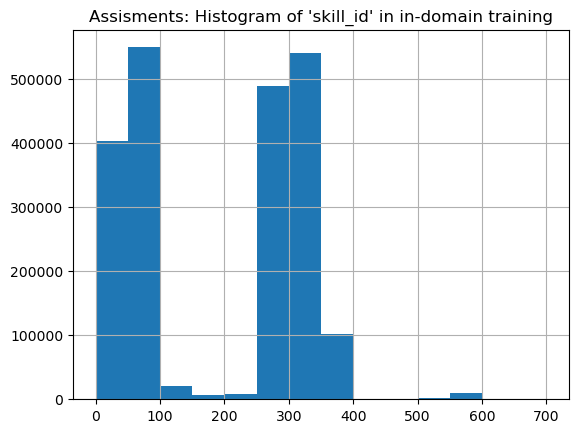

In [27]:
X_te, y_te, _, _ = dset.get_pandas("train")
X_te["skill_id"].hist(bins=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
plt.title("Assisments: Histogram of 'skill_id' in in-domain training")

In [10]:
tmp = {
                54.0: "Rounding",
                279.0: "Multiplication and Division Integers",
                79.0: "Proportion",
                86.0: "Exponents",
                311.0: "Equation Solving Two or Fewer Steps",
                11.0: "Venn Diagram",
                280.0: "Addition and Subtraction Fractions",
                338.0: "Combining Like Terms",
                81.0: "Unit Rate",
                325.0: "Write Linear Equation from Graph",
                322.0: "Write Linear Equation from Ordered Pairs",
                13.0: "Median",
                312.0: "Equation Solving More Than Two Steps",
                75.0: "Square Root",
                336.0: "Finding y-intercept from Linear Equation",
                315.0: "Parallel and Perpendicular Lines",
                340.0: "Distributive Property",
                70.0: "Percent Of",
                67.0: "Multiplication Fractions",
                277.0: "Addition and Subtraction Integers",
                24.0: "Congruence",
                363.0: "Multiplying non Monomial Polynomials",
                309.0:      "Order of Operations +,-,/,* () positive reals",
                324.0: "Recognize Linear Pattern",
                333.0: "Finding Slope From Equation",
                25.0: "Complementary and Supplementary Angles",
                378.0: "Solving Systems of Linear Equations by Graphing",
                49.0: "Ordering Positive Decimals",
                110.0: "D.4.8-understanding-concept-of-probabilities",
                42.0: "Perimeter of a Polygon",
                368.0: "Solving for a variable",
                12.0: "Mean",
                103.0: "Point Plotting",
                34.0: "Unit Conversion Within a System",
                47.0: "Conversion of Fraction Decimals Percents",
                61.0: "Division Fractions",
                296.0: "Area Rectangle",
                82.0: "Scientific Notation",
                15.0: "Range",
                51.0: "Ordering Integers",
                27.0: "Pythagorean Theorem",
                307.0: "Volume Rectangular Prism",
                65.0: "Least Common Multiple",
                323.0: "Write Linear Equation from Situation",
                326.0: "Write Linear Equation from Slope and y-intercept",
                46.0: "Calculations with Similar Figures",
                278.0: "Addition and Subtraction Positive Decimals",
                299.0: "Surface Area Cylinder",
                8.0: "Scatter Plot",
                77.0: "Finding Percents",
                163.0: "Absolute Value",
                523.0: "Picking Expressions From Choices",
                310.0: "Order of Operations All",
                80.0: "Scale Factor",
                297.0: "Area Trapezoid",
                39.0: "Area Circle",
                301.0: "Surface Area Rectangular Prism",
                302.0: "Surface Area Sphere",
                53.0: "Ordering Real Numbers",
                166.0: "Algebraic Solving",
                21.0: "Interior Angles Figures with More than 3 Sides",
                92.0: "Pattern Finding ",
                95.0: "Substitution",
                17.0: "Probability of Two Distinct Events",
                288.0: "Properties and Classification Rectangular Prisms",
                334.0: "Finding Slope from Ordered Pairs",
                282.0: "Properties and Classification Polygons with 5 or more sides",
                281.0: "Properties and Classification Triangles",
                371.0: "Simplifying Expressions positive exponents",
                84.0: "Prime Number",
                580.0: "Exponents",
                48.0: "Equivalent Fractions",
                314.0: "Angles - Obtuse, Acute, and Right",
                1.0: "Box and Whisker",
                362.0: "Parts of a Polyomial, Terms, Coefficient, Monomial, Exponent, Variable",
                350.0: "Solving Systems of Linear Equations",
                4.0: "Histogram as Table or Graph",
                306.0: "Volume Pyramid",
                298.0: "Area Triangle",
                83.0: "Divisibility Rules",
                294.0: "Area Irregular Figure",
                588.0: "Equivalent Fractions",
                577.0: "Nets of 3D Objects",
                331.0: "Finding Slope From Situation",
                569.0: "Surface Area Rectangular Prism",
                22.0: "Interior Angles Triangle",
                36.0: "Unit Conversion Standard to Metric",
                346.0: "Polynomial Factors",
                317.0: "Greatest Common Factor",
                332.0: "Finding Slope from Graph",
                90.0: "Picking Equation and Inequality from Choices",
                303.0: "Volume Cylinder",
                173.0: "Choose an Equation from Given Information",
                308.0: "Volume Sphere",
                217.0: "Rate",
                356.0: "Quadratic Formula to Solve Quadratic Equation",
                40.0: "Circumference ",
                283.0: "Properties and Classification Quadrilaterals",
                343.0: "Midpoint",
                295.0: "Area Parallelogram",
                392.0: "Surface Area of Prism",
                50.0: "Ordering Fractions",
                41.0: "Definition Pi",
                5.0: "Number Line",
                287.0: "Properties and Classification Prism",
                18.0: "Probability of a Single Event",
                276.0: "Multiplication and Division Positive Decimals",
                63.0: "Estimation",
                292.0: "Rotations",
                26.0: "Angles on Parallel Lines Cut by a Transversal",
                572.0: "Circumference",
                575.0: "Concept Volume",
                58.0: "Addition Whole Numbers",
                85.0: "Absolute Value",
                186.0: "Histogram as Table or Graph",
                358.0: "Making a Table from an Equation",
                284.0: "Properties and Classification Circle",
                584.0: "Multiplication Proper Fractions",
                574.0: "Subtraction Mixed Fractions",
                576.0: "Area Rectangle",
                366.0: "Composition of Function Adding",
                305.0: "Volume Cone",
                354.0: "Factoring Polynomials Standard",
                304.0: "Volume Prism",
                319.0: "Prime Factor",
                591.0: "Subtraction Proper Fractions",
                582.0: "Multiplication Positive Decimals",
                587.0: "Least Common Multiple",
                16.0: "Counting Methods",
                32.0: "Nets of 3D Figures",
                88.0: "Inverse Relations",
                365.0: "Interpreting Coordinate Graphs ",
                106.0: "Graph Shape",
                33.0: "English and Metric Terminology",
                375.0: "Solving Inequalities",
                1641.0: "Finding Ratios",
                62.0: "Division Whole Numbers",
                7.0: "Sampling Techniques",
                290.0: "Reflection",
                203.0: "Percent Discount",
                339.0: "Bar Graph",
                240.0: "X-Y Graph Reading",
                69.0: "Multiplication Whole Numbers",
                222.0: "Solving Inequalities",
                316.0: "Expanded, Standard and Word Notation",
                74.0: "Subtraction Whole Numbers",
                321.0: "Computation with Real Numbers",
                78.0: "Percent Increase or Decrease",
                391.0: "Graphing Linear Equations",
                230.0: "Surface Area of 3D Objects",
                327.0: "Comparing and Identifying Slope/Rate of Change",
                293.0: "Translations",
                10.0: "Table",
                300.0: "Surface Area Pyramid",
                9.0: "Stem and Leaf Plot",
                613.0: "Addition Mixed Fractions",
                360.0: "Writine Expression from Diagrams",
                387.0: "Perimeter of an Irregular Figure",
                14.0: "Mode",
                64.0: "Fraction Of",
                202.0: "Pattern Finding",
                318.0: "Multiplication Division by Powers of 10",
                344.0: "Distance Formula",
                231.0: "Symbolization",
                223.0: "Solving System of Equation",
                226.0: "Substitution",
                204.0: "Percents",
                6.0: "Line Plot",
                214.0: "Quadratic Equation Solving",
                585.0: "Division Proper Fractions",
                578.0: "Area Parallelogram",
                181.0: "Exponents",
                581.0: "Circle Concept",
                570.0: "Area Trapezoid",
                233.0: "Transformation",
                571.0: "Area Circle",
                583.0: "Multiplication Mixed Fractions",
                579.0: "Area Triangle",
                589.0: "Addition Proper Fractions",
                393.0: "Associative Property",
                198.0: "Median",
                370.0: "Recognizing Equivalent Expressions",
                376.0: "Graphing Inequalities on a number line",
                388.0: "Common Multiple",
                595.0: "Area Circle",
                599.0: "Concept Volume",
                52.0: "Ordering Whole Numbers",
                601.0: "Area Parallelogram",
                596.0: "Circumference",
                359.0: "Commutative Property",
                172.0: "Calculation with + - * /",
                2.0: "Circle Graph",
                224.0: "Square Roots",
                586.0: "Greatest Common Factor",
                35.0: "Effect of Changing Dimensions of a Shape Prportionally",
                568.0: "Volume Rectangular Prism",
                573.0: "Division Mixed Fractions",
                192.0: "Line of Best-Fit",
                238.0: "Volume of 3D Objects",
                345.0: "Properties and Clasification of Pyramid",
                605.0: "Multiplication Positive Decimals",
                313.0: "Tree Diagrams, Lists for Counting",
                597.0: "Division Mixed Fractions",
                216.0: "Range",
                386.0: "Odd and Even Number",
                213.0: "Pythagorean Theorem",
                206.0: "Factoring Trinomials",
                289.0: "Line Symmetry",
                165.0: "Algebraic Simplification",
                610.0: "Least Common Multiple",
                390.0: "Graph Shape",
                389.0: "Common Factor",
                212.0: "Proportion",
                593.0: "Surface Area Rectangular Prism",
                609.0: "Greatest Common Factor",
                606.0: "Multiplication Mixed Fractions",
                598.0: "Subtraction Mixed Fractions",
                385.0: "Elapsed Time",
                590.0: "Addition Mixed Fractions",
                594.0: "Area Trapezoid",
                184.0: "Geometric Definitions",
                218.0: "Finding Ratios",
                197.0: "Mean-Median-Mode-Range Differentiation",
                600.0: "Area Rectangle",
                196.0: "Mean",
                361.0: "Recognizing Expressions or Equations from Diagrams",
                603.0: "Exponents",
                614.0: "Subtraction Proper Fractions",
                608.0: "Division Proper Fractions",
                602.0: "Area Triangle",
                220.0: "Similar Figures",
                355.0: "Solve Quadratic Equations Using Factoring",
                592.0: "Volume Rectangular Prism",
                43.0: "Reading a Ruler or Scale",
                320.0: "Equal As Balance Concept",
                209.0: "Properties of Numbers",
                607.0: "Multiplication Proper Fractions",
                174.0: "Circle Graph",
                604.0: "Circle Concept",
                348.0: "Recognize Quadratic Pattern",
                612.0: "Addition Proper Fractions",
                178.0: "Combinatorics",
                611.0: "Equivalent Fractions",
                291.0: "Rotational Symmetry",
                177.0: "Co-ordinate Points",
            }
for key in sorted(tmp):
    print(key,tmp[key])

1.0 Box and Whisker
2.0 Circle Graph
4.0 Histogram as Table or Graph
5.0 Number Line
6.0 Line Plot
7.0 Sampling Techniques
8.0 Scatter Plot
9.0 Stem and Leaf Plot
10.0 Table
11.0 Venn Diagram
12.0 Mean
13.0 Median
14.0 Mode
15.0 Range
16.0 Counting Methods
17.0 Probability of Two Distinct Events
18.0 Probability of a Single Event
21.0 Interior Angles Figures with More than 3 Sides
22.0 Interior Angles Triangle
24.0 Congruence
25.0 Complementary and Supplementary Angles
26.0 Angles on Parallel Lines Cut by a Transversal
27.0 Pythagorean Theorem
32.0 Nets of 3D Figures
33.0 English and Metric Terminology
34.0 Unit Conversion Within a System
35.0 Effect of Changing Dimensions of a Shape Prportionally
36.0 Unit Conversion Standard to Metric
39.0 Area Circle
40.0 Circumference 
41.0 Definition Pi
42.0 Perimeter of a Polygon
43.0 Reading a Ruler or Scale
46.0 Calculations with Similar Figures
47.0 Conversion of Fraction Decimals Percents
48.0 Equivalent Fractions
49.0 Ordering Positive Decim

Text(0.5, 1.0, "Assisments: Histogram of 'skill_id' in in-domain testing")

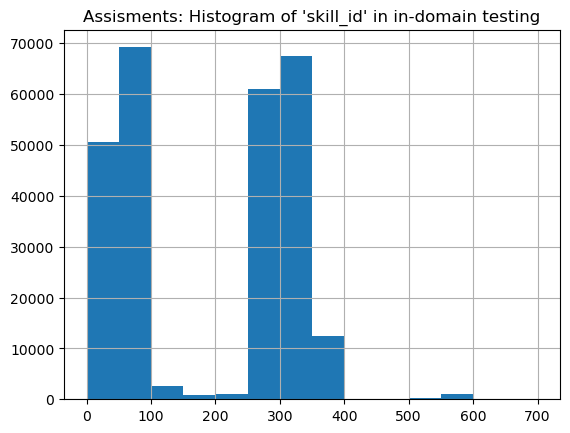

In [28]:
X_te, y_te, _, _ = dset.get_pandas("id_test")
X_te["skill_id"].hist(bins=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
plt.title("Assisments: Histogram of 'skill_id' in in-domain testing")

In [23]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, "Assisments: Histogram of 'skill_id' in out-of-domain testing")

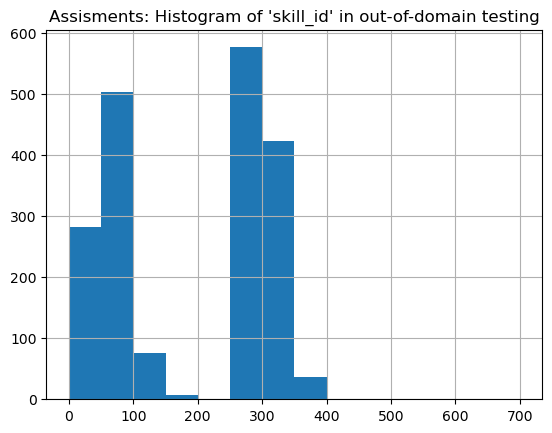

In [29]:
X_te, y_te, _, _ = dset.get_pandas("ood_test")
X_te["skill_id"].hist(bins=[0,50,100,150,200,250,300,350,400,450,500,550,600,650,700])
plt.title("Assisments: Histogram of 'skill_id' in out-of-domain testing")